# A Rigorous Machine Learning Pipeline (Supervised Binary Classification):
* Author: Ryan Urbanowicz, PhD 
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) 
* Date: 1/25/20
* Requirements: Anaconda (with Python 3), skrebate
    - Install most recent version of anaconda
    - [pip install skrebate]
    - [pip install xgboost]
    - [pip install lightgbm]
    - [pip install optuna]
    - [pip install -U plotly>=4.0.0]
    - [conda install -c plotly plotly-orca]

***
## Introduction
This notebook presents an example of a 'rigorous' machine learning (ML) analysis pipeline that could be reasonablly applied to various supervised learning classification tasks. This pipeline was developed with biomedical data mining/modeling in mind. The notebook is set up with the following assumptions:
- The user is starting from a single binary class dataset with a column for class labels (0 for major class, 1 for minor class), some number of potentially predictive feature/variables as columns, and (optionaly) a column providing instance id's and potentially other columns that should be excluded from analysis
- The user realizes that any unique dataset may require its own unique data cleaning, feature transformation, or feature engineering in order to maximize ML performance
- This pipeline is not necesarily ideal for all datasets, however it offers a rigorous starting point for analysis.
- Target dataset is saved in the working directory contiaining this notebook
- Target dataset is a .txt file (however notebook code may be modified to work with other file types)
- User knows the column names corresponding to all features to include in analysis as well as the column name corresponding to the outcome/endpoint/class to be included 
- All variables in the dataset have been numerically encoded (otherwise additional data preprocessing may be needed)

## Notebook Organization
#### Part 1: Exploratory analysis, data cleaning, and creating n-fold CV partitioned datasets 
- Instances missing a class value are excluded
- The user can indicate other columns that should be excluded from the analysis
- The user can turn on/off the option to apply standard scaling to the data prior to CV partitioning or imputation
    - We use no scaling by default. This is because most methods should work properly without it, and in applying the model downstream, it is difficult to properly scale new data so that models may be re-applied later.
    - ANN modeling is sensitive to feature scaling, thus without it, performance not be as good. However this is only one of many challenges in getting ANN to perform well. 
- The user can turn on/off the option to impute missing values following CV partitioning
- The user can turn on/off the option for the code to automatically attempt to discriminate nominal from ordinal features
- The user can choose the number of CV partitions as well as the strategy for CV partitioning (i.e.  random (R), stratified (S), and matched (M) 
- CV training and testing datasets are saved as .txt files so that the same partitions may be analyzed external to this code
    
#### Part 2: Feature selection
- The user can turn on/off the option to filter out the lowest scoring features in the data (i.e. to conduct not just feature importance evaluation but feature selection)
- Feature importance evaluation and feature selection are conducted within each respective CV training partition
- The pipeline reports feature importance estimates via two feature selection algorithms:
    - Mutual Information: Proficient at detecting univariate associations
    - MultiSURF: Proficient at detecting univariate associations, 2-way epistatic interactions, and heterogeneous associations
    
- When selected by the user, feature selection conservatively keeps any feature identified as 'potentially relevant' (i.e. score > 0) by either algorithm
- Since MultiSURF scales quadratically with the number of training instances, there is an option to utilize a random subset of instances when running this algorithm to save computational time
    
#### Part 3: Machine learning modeling
- Seven ML modeling algorithms have been implemented in this pipeline:
    - Logistic Regression (scikit learn)
    - Decision Tree (scikit learn)
    - Random Forest (scikit learn)
    - Naïve Bayes (scikit learn)
    - XGBoost (separate python package)
    - LightGBM (separate python package)
    - SVM (scikit learn)
    - ANN (scikit learn)
    - ExSTraCS (v2.0.2.1) - a Learning Classifier System (LCS) algorithm manually configured to run in this notebook
- User can select any subset of these methods to run
- ML modeling is conducted within each respective CV training partition on the respective feature subset selected within the given CV partition
- ML modeling begins with a hyperparameter sweep conducted with a grid search of hard coded run parameter options (user can edit as needed)
- Balanced accuracy is applied as the evaluation metric for the hyperparameter sweep

#### Part 4: ML feature importance vizualization

***
## Schematic of ML Analysis Pipeline

<img src="ML pipeline schematic.png" />

---
# Import Necessary Python Packages 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import copy
import sys
import pickle
import time

from data_processing_methods import cv_partitioner
from data_processing_methods import identifyCategoricalFeatures
from data_processing_methods import imputeCVData
from data_processing_methods import dataScaling

from feature_selection_methods import reportAllFS
from feature_selection_methods import reportTopFS
from feature_selection_methods import sort_save_fi_scores
from feature_selection_methods import sort_save_fs_fi_scores
from feature_selection_methods import run_mi
from feature_selection_methods import run_multisurf
from feature_selection_methods import selectFeatures
from feature_selection_methods import genFilteredDatasets

from modeling_methods import classEval
from modeling_methods import roc_plot_single
from modeling_methods import save_performance
from modeling_methods import save_FI
from modeling_methods import eval_Algorithm_FI
from modeling_methods import eval_LCS
from modeling_methods import eval_LCS_QRF

#LCS package
#sys.path.append('C:/home/work/research_urbslab/Core_ML_Pipeline/ml_pipeline_lcs/exstracs_2.0.2.1_noclassmutate_lynch')
#import exstracs_main

#Statistics packages
from scipy import stats

#Visualization Packages:
#This code ensures that the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
from matplotlib import rc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import Progress bar:
from tqdm import tnrange, tqdm_notebook

C:\Users\ryanu\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


---
# Set Dataset Pipeline Variables (Mandatory)
These variables values will have to be respecified to run this pipeline on a given dataset or computer

In [2]:
#Unique dataset name (include dataset extension) (must be updated for a given dataset analysis)
target_data = 'Epi_DietAdj_20180710.txt' 

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'panc_type01' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = 'plco_id' #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = ['arm','panscan_in_study','panscan3_in_study','hispanic_f']  #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

---
# Set Other Pipeline Variables (Optional) 
These variables can be left as is, or modified to update key aspects of how the ML pipeline will be run and what methods will be included

In [3]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#ML Modeling -----------------------------------------------------------------------------------------------------
#Algorithms available: logistic_regression,decision_tree, random_forest, naive_bayes, xg_boost, lg_boost, SVM, ANN
algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','LCS','LCS_QRF'] 
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','LCS','LCS_QRF')
algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'pink', 'green', 'blue']

"""
algorithmsToRun = ['logistic_regression'] 
methodsKey = ('Logistic Regression')
algColors = ['black']

algorithmsToRun = ['decision_tree'] 
methodsKey = ('Decision Tree')
algColors = ['black']

algorithmsToRun = ['random_forest'] 
methodsKey = ('Random Forest')
algColors = ['black']

algorithmsToRun = ['XGB'] 
methodsKey = ('XGB')
algColors = ['black']

algorithmsToRun = ['LGB'] 
methodsKey = ('LGB')
algColors = ['black']

algorithmsToRun = ['SVM'] 
methodsKey = ('SVM')
algColors = ['black']

algorithmsToRun = ['ANN'] 
methodsKey = ('ANN')
algColors = ['black']

"""
#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

"\nalgorithmsToRun = ['logistic_regression'] \nmethodsKey = ('Logistic Regression')\nalgColors = ['black']\n\nalgorithmsToRun = ['decision_tree'] \nmethodsKey = ('Decision Tree')\nalgColors = ['black']\n\nalgorithmsToRun = ['random_forest'] \nmethodsKey = ('Random Forest')\nalgColors = ['black']\n\nalgorithmsToRun = ['XGB'] \nmethodsKey = ('XGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['LGB'] \nmethodsKey = ('LGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['SVM'] \nmethodsKey = ('SVM')\nalgColors = ['black']\n\nalgorithmsToRun = ['ANN'] \nmethodsKey = ('ANN')\nalgColors = ['black']\n\n"

## ML Modeling Hyperparamters

In [4]:
#Optima Hyperparameter sweep run parameters
n_trials = 100 #number of bayesian hyperparameter optimization trials (using optuna)
scoring_metric = 'balanced_accuracy' #metric used to pick best hyperparamters
hype_cv = 3 #Internal cv partitions for hyperparamter sweep evaluations
timeout = 300 #Seconds until hyperparameter sweep stopped - 3600 sec = 1 hour, 300 sec = 5 min

#Logistic Regression
param_grid_LR = {'penalty' : ['l2','l1'],
                'C' : [1e-5, 1e5], 
                'dual' : [True, False],
                'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag','saga'],
                'class_weight' : [None, 'balanced'],
                'max_iter' : [10, 1000],
                'n_jobs' : [-1]}

#Decision Tree
param_grid_DT = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'class_weight' : [None, 'balanced']}

#Random Forest
param_grid_RF = {'n_estimators': [10,1000],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'bootstrap' : [True],
                'oob_score' : [False, True],
                'n_jobs' : [-1],
                'class_weight' : [None, 'balanced']}

#XG Boost - note: class weight balance is included as option internally
param_grid_XGB = {'booster': ['gbtree'],
                'objective' : ['binary:logistic'],
                'verbosity' : [0],
                'reg_lambda' : [1e-8, 1.0],
                'alpha' : [1e-8, 1.0],
                'eta' : [1e-8, 1.0],
                'gamma' : [1e-8, 1.0],
                'max_depth' : [1, 30],
                'grow_policy' : ['depthwise', 'lossguide'],
                'n_estimators': [10,1000],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'subsample' : [0.5, 1.0],
                'min_child_weight': [0.1, 10],
                'colsample_bytree': [0.1, 1.0]}

#LG Boost - note: class weight balance is included as option internally
param_grid_LGB = {'objective' : ['binary'],
                'metric': ['binary_logloss'],
                'verbosity' : [-1],
                'boosting_type': ['gbdt'],
                'num_leaves': [2,256],
                'max_depth' : [1, 30],
                'lambda_l1': [1e-8, 10.0],
                'lambda_l2': [1e-8, 10.0],
                'feature_fraction': [0.4, 1.0],
                'bagging_fraction': [0.4, 1.0],
                'bagging_freq': [1,7],
                'min_child_samples': [5,100],
                'n_estimators': [10,1000]}

#SVM
param_grid_SVM = {'kernel' : ['linear','poly','rbf'],
                'C': [0.1, 1000],
                'gamma': ['scale'],
                'degree': [1,6],
                'probability' : [True],
                'class_weight' : [None, 'balanced']}
        
#ANN
param_grid_ANN = {'n_layers' : [1,3],
                'layer_size' : [1,100],
                'activation': ['identity','logistic', 'tanh', 'relu'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'momentum': [.1,.9],
                'solver': ['sgd', 'adam'],
                'batch_size': ['auto'],
                'alpha': [0.0001, 0.05],
                'max_iter' : [200]}

param_grid = {} #stores all user selected algorithm hyperparameters

for algorithm in algorithmsToRun: #['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'xg_boost','SVM','ANN'] 
    if algorithm == 'logistic_regression':
        param_grid['logistic_regression'] = param_grid_LR
    elif algorithm == 'decision_tree':
        param_grid['decision_tree'] = param_grid_DT
    elif algorithm == 'random_forest':
        param_grid['random_forest'] = param_grid_RF
    elif algorithm == 'naive_bayes':
        pass #no hyperparameters
    elif algorithm == 'XGB':
        param_grid['XGB'] = param_grid_XGB
    elif algorithm == 'LGB':
        param_grid['LGB'] = param_grid_LGB
    elif algorithm == 'SVM':
        param_grid['SVM'] = param_grid_SVM
    elif algorithm == 'ANN':
        param_grid['ANN'] = param_grid_ANN
    elif algorithm =='LCS':
        pass #parameters are set directly
    elif algorithm =='LCS_QRF':
        pass #parameters are set directly
    else:
        print("Error: Algorithm not found!")

#LCS Hyperparameters (not set up for parameter sweep - uses specified and default hyperparameters)
lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch/exstracs_main.py' #LCS file to call
iterations = 200000
popsize = 2000
lcs_alg = 'ExSTraCS_2.0.2.1'

#Visualization ---------------------------------------------------------------------------------------------------
focus_metric = 'Balanced Accuracy'

#Statistical Significance-----------------------------------------------------------------------------------------
sig_cutoff = 0.05

---
# Notebook/Folder Initialization
For simplicity it is recommended that this not be altered.

In [5]:
#Standard Names (no need to change)
output_folder = 'results'
cv_data_folder = 'cv_datasets'
ua_folder = 'univariate'
model_folder = 'models'
lcs_folder = 'lcs'

#Working directory path automatically detected
wd_path = os.getcwd()
wd_path = wd_path.replace('\\','/')
wd_path = wd_path+'/'
print("Working Directory: "+wd_path)

#Save data name without extension for later file labeling
data_name = target_data.split('.')[0] 

#Create output folder if it doesn't already exist
if not os.path.exists(wd_path+(output_folder)):
    os.mkdir(wd_path+(output_folder))

#Create CV dataset folder if it doesn't already exist
if not os.path.exists(wd_path+(cv_data_folder)):
    os.mkdir(wd_path+(cv_data_folder))

#Create univariate analysis folder if it doesn't already exist
if not os.path.exists(wd_path+(ua_folder)):
    os.mkdir(wd_path+(ua_folder))
    
#Create model pickle folder if it doesn't already exist
if not os.path.exists(wd_path+(model_folder)):
    os.mkdir(wd_path+(model_folder))
    
#Create LCS output folder if it doesn't already exist
if not os.path.exists(wd_path+(lcs_folder)):
    os.mkdir(wd_path+(lcs_folder))

data_changed = False #Keeps track of whether cleaning changed original dataset (leave this set to False)

run_time_dict = {}
notebook_start_time = time.time()

Working Directory: C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj/


---
# Load Dataset
This code assumes that the data is being loaded as a tab delimited '.txt' file with columns as features/outcome, and rows as instances. It is also assumed that the target file includes a header and that missing values are indicated with 'NA' or an empty cell. This command can be updated depending on users dataset format. 

In [6]:
td = pd.read_csv(target_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape

(5128, 43)

### Debugging data simplification (This code should be commented out during normal run)

In [7]:
#td = td.sample(frac=0.5, replace=False, random_state=randomSeed)

---
# Initial Exploratory Analysis

In [8]:
# Count the number of rows and columns
num_rows = td.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = td.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 5128 rows.
Dataset contains 43 columns.


In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5128 entries, 0 to 5127
Data columns (total 43 columns):
panc_type01            5098 non-null float64
cig_stat               5098 non-null float64
cig_stop               2963 non-null float64
cig_years              5029 non-null float64
pack_years             5026 non-null float64
total_alcadj           4886 non-null float64
total_fatadj           4886 non-null float64
tot_Kcal               4886 non-null float64
totalcarbadj           4886 non-null float64
total_proteinadj       4886 non-null float64
totalfolate_NDSRadj    4886 non-null float64
total_GlyIndex         4887 non-null float64
total_GlyLoad          4887 non-null float64
totalcholadj           4886 non-null float64
Totalredmeatadj        4886 non-null float64
totalCALCIUMadj        4886 non-null float64
bmi_curc               5044 non-null float64
bmi_curr               5044 non-null float64
diabetes_f             5079 non-null float64
panc_fh                5051 non-null f

In [10]:
td.describe()

panc_type01     cig_stat     cig_stop    cig_years   pack_years  \
count  5098.000000  5098.000000  2963.000000  5029.000000  5026.000000   
mean      0.156924     1.079639    17.651704    16.095347    22.078193   
std       0.363765     0.944161    13.566540    17.077058    29.640964   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     5.000000     0.000000     0.000000   
50%       0.000000     1.000000    17.000000    12.000000    10.000000   
75%       0.000000     2.000000    29.000000    31.000000    36.750000   
max       1.000000     2.000000    54.000000    64.000000   230.000000   

       total_alcadj  total_fatadj     tot_Kcal  totalcarbadj  \
count   4886.000000   4886.000000  4886.000000   4886.000000   
mean       0.005776      0.033486  2217.155888      0.131477   
std        0.009861      0.007001   940.965187      0.021374   
min        0.000000      0.004019   169.208000      0.026210   
25%        0.000142      0.028787  1582.942250      0.117864   
50%        0.001260      0.033482  2075.820500      0.131858   
75%        0.007128      0.038017  2673.195250      0.145263   
max        0.086527      0.078956  9599.991000      0.251585   

       total_proteinadj  totalfolate_NDSRadj  total_GlyIndex  total_GlyLoad  \
count       4886.000000          4886.000000     4887.000000    4887.000000   
mean           0.039104             0.235049       54.910912     144.856649   
std            0.006463             0.062231        4.042824      63.204690   
min            0.010426             0.065040        0.000000       0.000000   
25%            0.034969             0.194683       52.476263     102.448000   
50%            0.039028             0.228055       54.683793     134.928000   
75%            0.042988             0.265138       57.085433     175.742000   
max            0.104329             0.791301       77.595628     754.611000   

       totalcholadj  Totalredmeatadj  totalCALCIUMadj     bmi_curc  \
count   4886.000000      4886.000000      4886.000000  5044.000000   
mean       0.114633         0.039453         0.553916     2.951427   
std        0.042117         0.023251         0.267141     0.728325   
min        0.000114         0.000000         0.112611     1.000000   
25%        0.086965         0.023059         0.380767     2.000000   
50%        0.107996         0.035637         0.487032     3.000000   
75%        0.134425         0.051204         0.650056     3.000000   
max        0.569507         0.328334         4.248794     4.000000   

          bmi_curr   diabetes_f      panc_fh    fh_cancer       bmi_20  \
count  5044.000000  5079.000000  5051.000000  5086.000000  5027.000000   
mean     27.476038     0.092932     0.347852     0.551514    22.678953   
std       4.303685     0.290365     1.679806     0.497388     3.013834   
min      15.917498     0.000000     0.000000     0.000000    15.053320   
25%      24.463433     0.000000     0.000000     0.000000    20.569599   
50%      26.834556     0.000000     0.000000     1.000000    22.362130   
75%      29.820429     0.000000     0.000000     1.000000    24.417188   
max      51.757345     1.000000     9.000000     1.000000    43.838472   

            bmi_50          asp        asppd         ibup       ibuppd  \
count  5048.000000  5066.000000  5083.000000  5082.000000  5077.000000   
mean     26.317950     0.500000     1.568955     0.244392     1.103801   
std       3.796642     0.500049     2.192550     0.429768     2.133281   
min      15.236740     0.000000     0.000000     0.000000     0.000000   
25%      23.759763     0.000000     0.000000     0.000000     0.000000   
50%      25.856213     0.500000     1.000000     0.000000     0.000000   
75%      28.187969     1.000000     2.000000     0.000000     1.000000   
max      56.795104     1.000000     7.000000     1.000000     7.000000   

        gallblad_f  liver_comorbidity          age     agelevel       educat  \
count 

In [11]:
td.dtypes

panc_type01            float64
cig_stat               float64
cig_stop               float64
cig_years              float64
pack_years             float64
total_alcadj           float64
total_fatadj           float64
tot_Kcal               float64
totalcarbadj           float64
total_proteinadj       float64
totalfolate_NDSRadj    float64
total_GlyIndex         float64
total_GlyLoad          float64
totalcholadj           float64
Totalredmeatadj        float64
totalCALCIUMadj        float64
bmi_curc               float64
bmi_curr               float64
diabetes_f             float64
panc_fh                float64
fh_cancer              float64
bmi_20                 float64
bmi_50                 float64
asp                    float64
asppd                  float64
ibup                   float64
ibuppd                 float64
gallblad_f             float64
liver_comorbidity      float64
age                      int64
agelevel                 int64
educat                 float64
race7   

In [12]:
td.nunique()

panc_type01               2
cig_stat                  3
cig_stop                 54
cig_years                62
pack_years              174
total_alcadj           4038
total_fatadj           4884
tot_Kcal               4884
totalcarbadj           4883
total_proteinadj       4878
totalfolate_NDSRadj    4886
total_GlyIndex         4776
total_GlyLoad          4817
totalcholadj           4885
Totalredmeatadj        4884
totalCALCIUMadj        4886
bmi_curc                  4
bmi_curr               1283
diabetes_f                2
panc_fh                   3
fh_cancer                 2
bmi_20                  777
bmi_50                  928
asp                       2
asppd                     8
ibup                      2
ibuppd                    8
gallblad_f                2
liver_comorbidity         2
age                      20
agelevel                  4
educat                    7
race7                     7
hispanic_f                2
total_Marital             5
occupat             

### Assess Missingness in Columns

In [13]:
for i,c in enumerate(td.columns):
    na_percent = np.sum(td[c].isnull())/len(td)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(td[c].isnull())/len(td)*100)

panc_type01 		% Missing(N/A) =  0.5850234009360374
cig_stat 		% Missing(N/A) =  0.5850234009360374
cig_stop 		% Missing(N/A) =  42.219188767550705
cig_years 		% Missing(N/A) =  1.9305772230889238
pack_years 		% Missing(N/A) =  1.989079563182527
total_alcadj 		% Missing(N/A) =  4.719188767550702
total_fatadj 		% Missing(N/A) =  4.719188767550702
tot_Kcal 		% Missing(N/A) =  4.719188767550702
totalcarbadj 		% Missing(N/A) =  4.719188767550702
total_proteinadj 		% Missing(N/A) =  4.719188767550702
totalfolate_NDSRadj 		% Missing(N/A) =  4.719188767550702
total_GlyIndex 		% Missing(N/A) =  4.699687987519501
total_GlyLoad 		% Missing(N/A) =  4.699687987519501
totalcholadj 		% Missing(N/A) =  4.719188767550702
Totalredmeatadj 		% Missing(N/A) =  4.719188767550702
totalCALCIUMadj 		% Missing(N/A) =  4.719188767550702
bmi_curc 		% Missing(N/A) =  1.6380655226209049
bmi_curr 		% Missing(N/A) =  1.6380655226209049
diabetes_f 		% Missing(N/A) =  0.9555382215288611
panc_fh 		% Missing(N/A) =  1.50

Text(0.5, 0, 'Missing Value Counts')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Missing Value Counts In Feature Set')

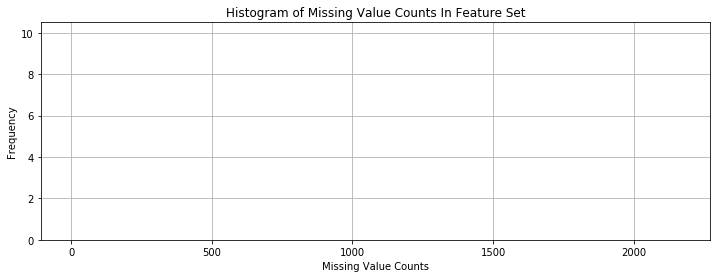

In [14]:
missing_count = td.isnull().sum()
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_rows,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

---
# Data Cleaning

### Remove instances (rows) with missing outcome values

In [15]:
print("Number of training instances in original dataset = ",num_rows)
td = td.dropna(axis=0,how='any',subset=[outcomeLabel])
print("Number of training instances after removing instances with missing endpoint = ",len(td))
diff = num_rows-len(td)
print("Number of instances removed = ", diff)
num_rows = len(td) #reassign value (if changed)
if diff > 0:
    data_changed = True
td.shape

Number of training instances in original dataset =  5128
Number of training instances after removing instances with missing endpoint =  5098
Number of instances removed =  30


(5098, 43)

In [16]:
#It's critical to reset the index after dropping rows to work with data frame later with pd.concat of separate columns
td = td.reset_index(drop=True)
td.shape
#Ensure Class variable is cast as an int
td[outcomeLabel] = td[outcomeLabel].astype(dtype='int64')
td.info()

(5098, 43)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 43 columns):
panc_type01            5098 non-null int64
cig_stat               5069 non-null float64
cig_stop               2946 non-null float64
cig_years              5000 non-null float64
pack_years             4997 non-null float64
total_alcadj           4857 non-null float64
total_fatadj           4857 non-null float64
tot_Kcal               4857 non-null float64
totalcarbadj           4857 non-null float64
total_proteinadj       4857 non-null float64
totalfolate_NDSRadj    4857 non-null float64
total_GlyIndex         4858 non-null float64
total_GlyLoad          4858 non-null float64
totalcholadj           4857 non-null float64
Totalredmeatadj        4857 non-null float64
totalCALCIUMadj        4857 non-null float64
bmi_curc               5015 non-null float64
bmi_curr               5015 non-null float64
diabetes_f             5050 non-null float64
panc_fh                5022 non-null flo

In [17]:
#Confirm no missing values in outcome variable
na_percent = np.sum(td[outcomeLabel].isnull())/len(td[outcomeLabel])*100
if na_percent > 0:
    print(c,'\t\t% Missing(N/A) = ',np.sum(td[outcomeLabel].isnull())/len(td)*100)
else:
    print('No missing values found in: '+ str(outcomeLabel))

No missing values found in: panc_type01


### Remove columns to be ignored in analysis

In [18]:
print("Number of columns in original dataset = ", num_cols)
td = td.drop(ignore_columns, axis=1)
print("Number of columns after removing ignored columns = ", len(td.columns))
diff = num_cols-len(td.columns)
print("Number of columns removed = ", diff)
num_cols = len(td.columns)
if diff > 0:
    data_changed = True
td.shape

Number of columns in original dataset =  43
Number of columns after removing ignored columns =  39
Number of columns removed =  4


(5098, 39)

### Assess class imbalance (assuming discrete outcome)

Counts of each class
0    4298
1     800
Name: panc_type01, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

(5098, 39)

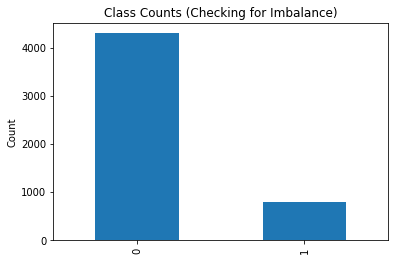

In [19]:
print("Counts of each class")
print(td[outcomeLabel].value_counts())
td[outcomeLabel].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
td.shape

### Identify categorical variables in dataset

In [20]:
if autoDetectCategorical:
    #Separate independent variables from the rest
    if instLabel == None or instLabel == 'None':
        x_data = td.drop([outcomeLabel], axis=1)
    else:
        x_data = td.drop([outcomeLabel,instLabel], axis=1)

    categorical_variables = identifyCategoricalFeatures(x_data,categoricalCutoff)
    #print(categorical_variables)
    td.shape

(5098, 39)

---
# Example Code for other potential data cleaning/processing
- Not applied in this example script, but available here as an example

### Delete Rows/Instances with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [21]:
#num_rows = td.shape[0]
#print("Number of training instances in original dataset = ",num_rows)
#td = td.dropna()
#print("Number of training instances after removing instances with any missing values = ",td.shape[0])
#diff = num_rows-td.shape[0]
#if diff > 0:
#    data_changed = True

### Delete Columns with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [22]:
#num_cols = td.shape[1]
#print("Number of training instances in original dataset = ",num_cols)
#td = df.dropna(axis='columns')
#print("Number of training instances after removing instances with any missing values = ",td.shape[1])
#diff = num_cols-td.shape[1]
#if diff > 0:
#    data_changed = True

### One hot encoding of categorical variables
- Ensures that categorical variables are not treated in an ordinal manner by ML algorithms
- The code below is an example of how to convert a single column to one hot encoding, and is not meant to be run as is. 

In [23]:
## Example below assumes a data frame 'df' with a column called 'B'
#one_hot = pd.get_dummies(df['B'])
#df = df.drop('B',axis = 1)
#df = df.join(one_hot)

### Other possible cleaning steps:
- encode text values as numerics
- oversample or undersample to reduce class imbalance
- drop additional rows based on assigned cutoffs, etc
- cast variable types as nominal or ordinal
- construct missingness features with MissingIndicator: https://scikit-learn.org/stable/modules/impute.html

In [24]:
#Saved for later, determines if imputation attempted.
isMissingData = False
if td.isnull().values.any():
    isMissingData = True

## Save cleaned dataset if it has been modified

In [25]:
if data_changed:
    print('Saving cleaned data.')
    td.shape
    data_name = data_name +'_clean'
    td.to_csv(data_name+'.txt', index=None, sep='\t')

Saving cleaned data.


(5098, 39)

---
# Further Exploratory/Descriptive Analysis
- Visualize feature correlations in data
- Appropriate univariate analyses

## Feature Correlations

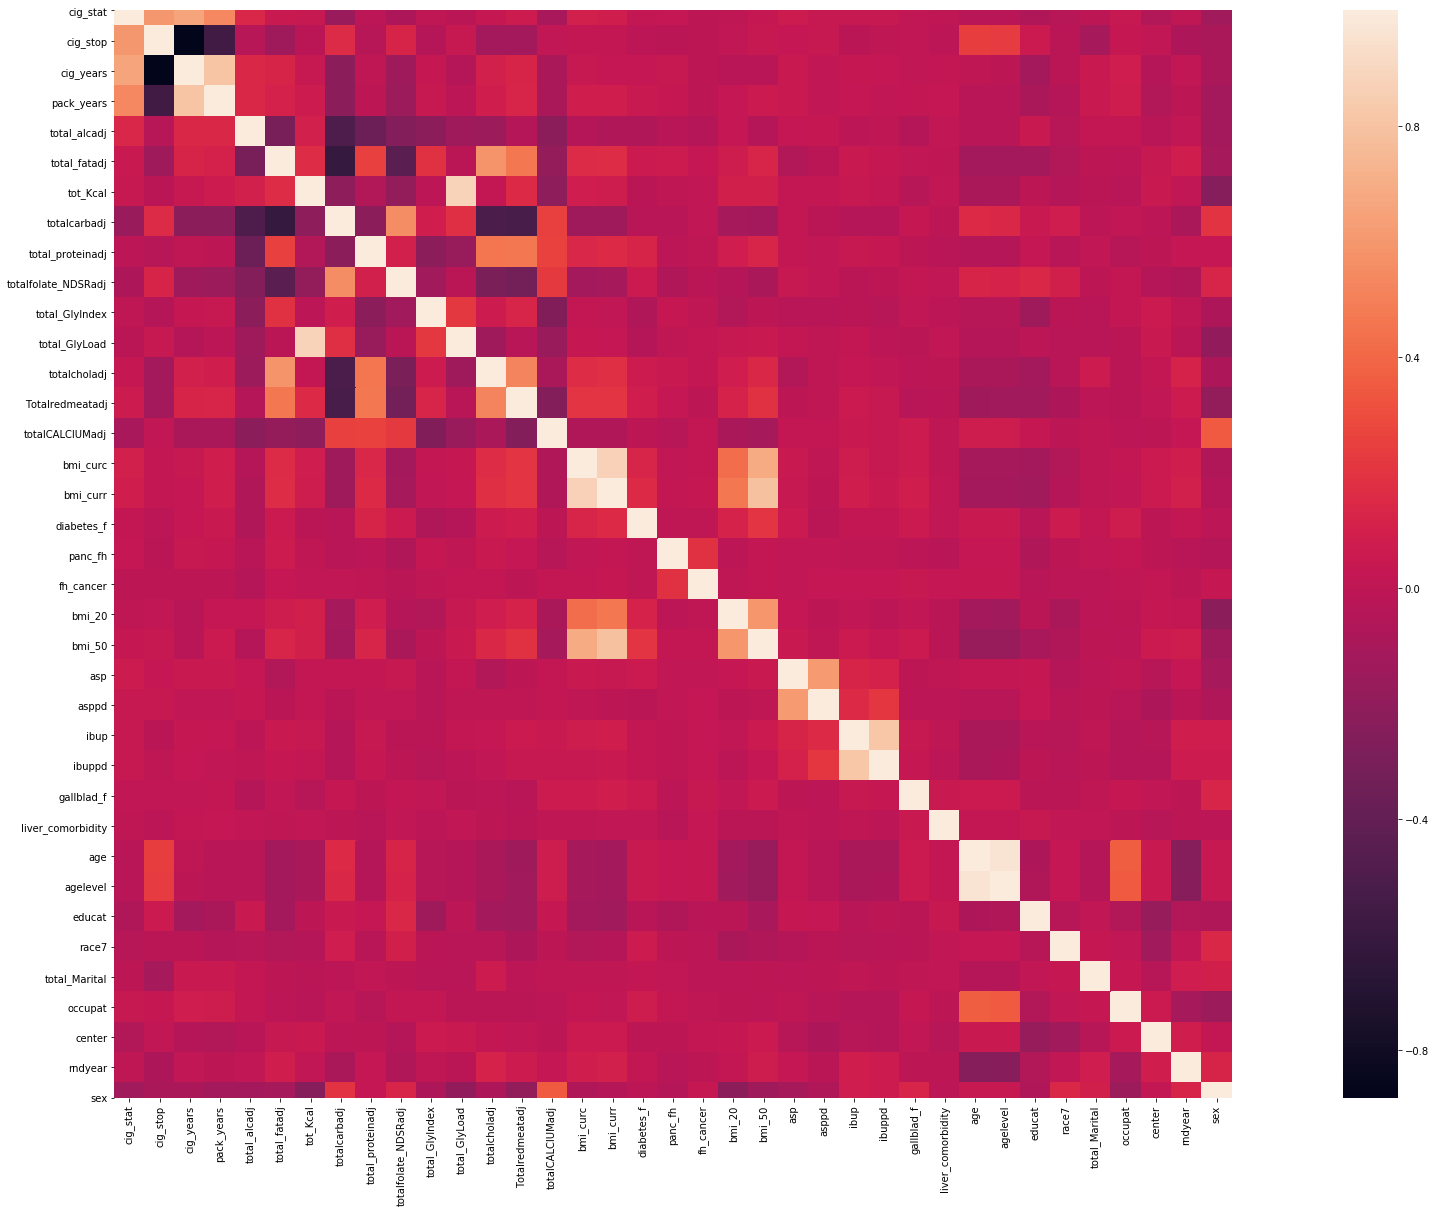

In [26]:
if doCorrelation:
    #Drop outcome column for correlation analysis
    td_cor = td.drop([outcomeLabel], axis=1)
    
    #Compute correlation between the outcome and each feature , excluding NA/null values.
    corrmat = td_cor.corr(method='pearson') 
    f, ax = plt.subplots(figsize = (40,20)) # Note: need large size
    sns.heatmap(corrmat, vmax =1.0,square = True) # Set max value and square-shaped


## Univariate Analysis and Plots
Below we have encoded a method to automatically select an appropriate plot and univariate association test between a single feature and the target outcome in the dataset.

In [27]:
# Code to analyze the univariate relationship between the outcome and each feature
def test_selector(featureName, outcomeLabel, td, categorical_variables):
    p_val = 0
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        p_val = p
        
    #Feature is continuous and Outcome is discrete/categorical/binary
    else: 
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=td[featureName].loc[td[outcomeLabel] == 0],y=td[featureName].loc[td[outcomeLabel] == 1])
        p_val = p
        
    return p_val

In [28]:
# Function select appropriate visualizations to examine univariate relationships between each feature and outcome

def graph_selector(featureName, outcomeLabel, td, categorical_variables):
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Barplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight")
        plt.show()
        
    #Feature is continuous and Outcome is discrete/categorical/binary    
    else: 
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        mygraph = td.boxplot(column=featureName,by=outcomeLabel)
        plt.ylabel(featureName)
        plt.title('')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Boxplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight")
        plt.show()

Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
sex: (p-val = 7.391784443712373e-86)
race7: (p-val = 2.536193502544118e-48)
occupat: (p-val = 5.388311021561456e-26)
totalCALCIUMadj: (p-val = 1.462897094127897e-21)
center: (p-val = 1.592156210115093e-20)
total_fatadj: (p-val = 4.98072356381827e-16)
totalcarbadj: (p-val = 6.935774954865501e-15)
totalcholadj: (p-val = 4.616757732356713e-12)
total_proteinadj: (p-val = 8.316891753991312e-12)
cig_stop: (p-val = 1.6687279079980054e-11)
totalfolate_NDSRadj: (p-val = 4.9250952838656346e-11)
cig_stat: (p-val = 8.770533043202116e-11)
total_alcadj: (p-val = 9.547808672373107e-10)
gallblad_f: (p-val = 1.6008209713688788e-07)
total_Marital: (p-val = 5.2949541626533e-07)
cig_years: (p-val = 4.318980433391872e-06)
Totalredmeatadj: (p-val = 0.0001375418916340198)
bmi_curc: (p-val = 0.00014863382844742507)
pack_years: (p-val = 0.000383585153873031)
age: (p-val = 0.00090535929

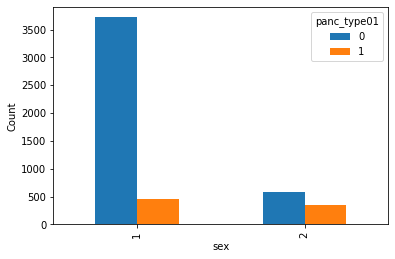

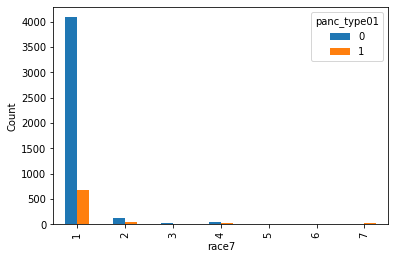

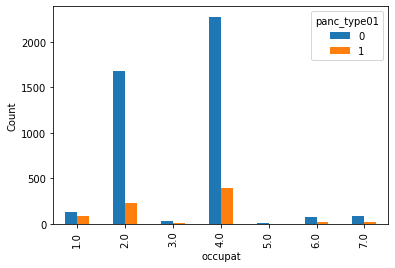

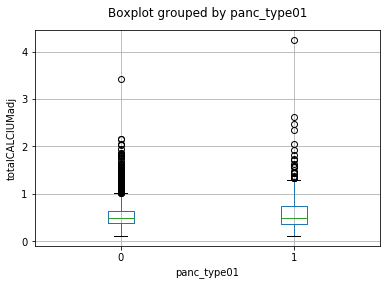

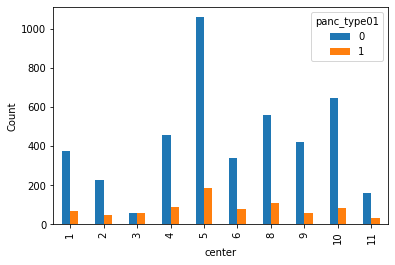

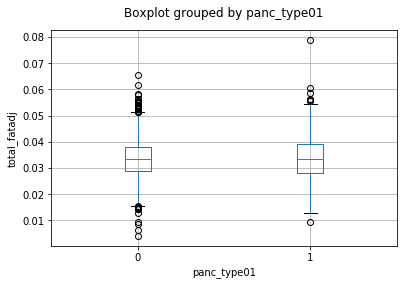

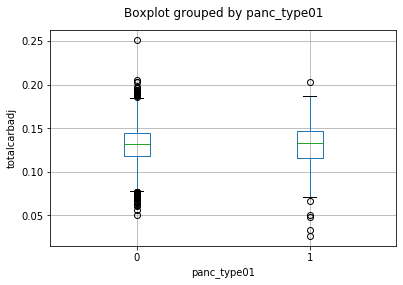

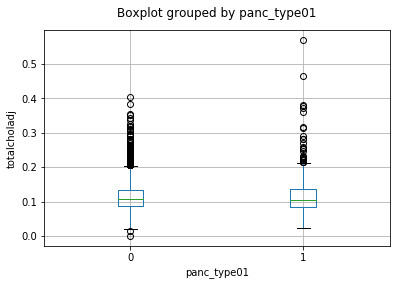

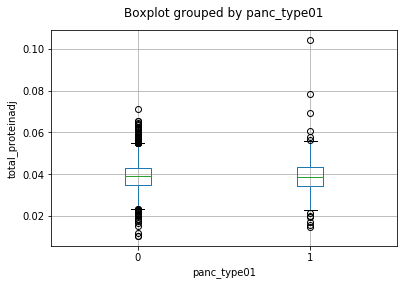

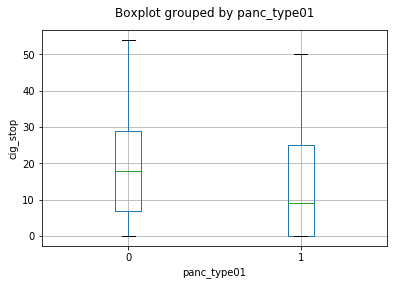

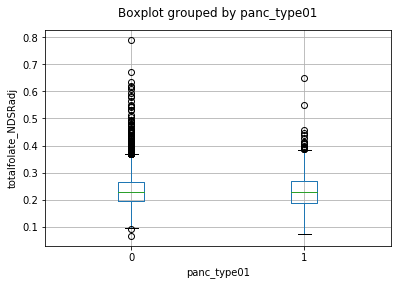

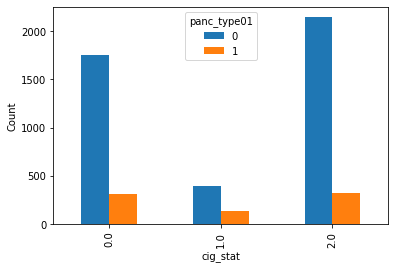

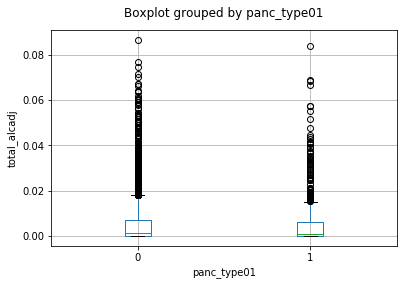

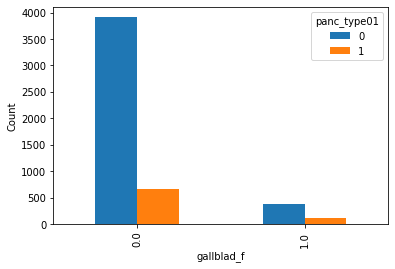

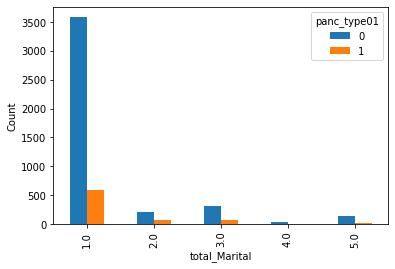

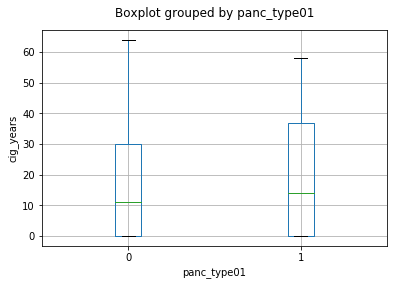

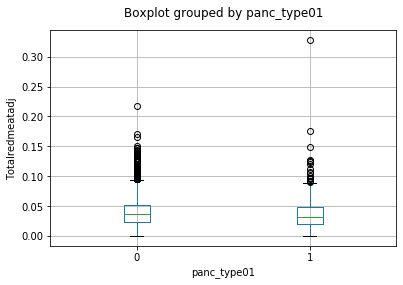

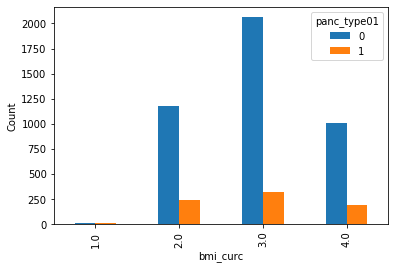

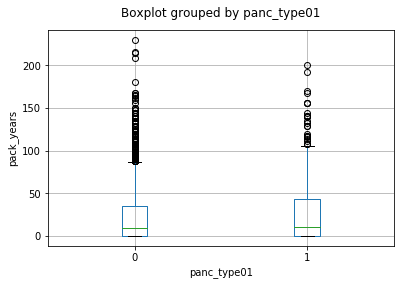

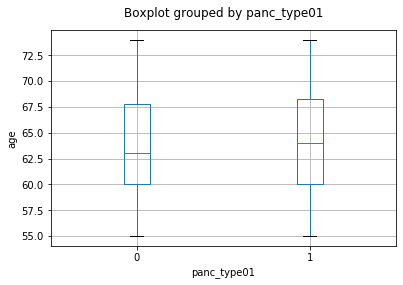

In [29]:
if doUA:
    p_val_dict = {}
    # run appropriate univariate association test for each independent variable
    for each in td:
        if each != outcomeLabel: 
            p_val_dict[each] = test_selector(each, outcomeLabel, td, categorical_variables)
    
    num_features = td.shape[1] - 1
    
    sorted_p_list = sorted(p_val_dict.items(), key = lambda item:item[1])
    
    #Save all p-values to file
    pval_df = pd.DataFrame.from_dict(p_val_dict, orient='index')
    filepath = wd_path+ua_folder+'/'+'UA_Significance_'+data_name+'.csv'
    pval_df.to_csv(filepath, header=['p-value'], index=True)  
    
    min_num = min(topResults,num_features)
    sorted_p_list = sorted_p_list[: min_num]
    print('Plotting top significant '+ str(min_num) + ' features.')
    
    # summarize significant values of selected number of features
    print('###################################################')
    print('Significant Univariate Associations:')
    for each in sorted_p_list[:min_num]:
        print(each[0]+": (p-val = "+str(each[1]) +")")

    #generate appropriate descriptive plot for selected number of features
    for i in sorted_p_list:
        for j in td:
            if j == i[0]:# if the feature name is within the selected feature list
                graph_selector(j, outcomeLabel, td, categorical_variables) #plot appropriate figure for each feature

---
# Create n-fold Cross Validation (CV) Datasets 
- i.e. Training and Testing Datasets

In [30]:
#Create a header list of independant feature names
header = td.columns.values.tolist()
header.remove(outcomeLabel)
if instLabel != None and instLabel != 'None':
    header.remove(instLabel)

#Perform CV partitioning (get back list of training and testing partition dataframes)
train_dfs, test_dfs = cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed)

if partition_method == 'M':
    header.remove(matchName)

Nominal Stratitifed Partitioning


---
# Transform data - Standard Scaling
- Features are independently scaled to allow them to be more comparable in downstream logistic regression modeling, etc
- Scaling is learned on the training data and saved with pickel so that the same scaling may be applied to any future testing data
- Completed within each training and testing partition independently

In [31]:
if scaleData:
    print('Scaling Data')
    data_name = data_name +'_scale'
    name_path = wd_path+model_folder+'/'+'Scalar_' + data_name+'_'
    train_dfs, test_dfs = dataScaling(train_dfs, test_dfs, outcomeLabel, instLabel, name_path, header)

Scaling Data


---
# Impute Missing Data Values
- Missing data values in categorical features are imputed with simple 'mode' imputation
- Remaining missing data values are imputed using Iterative Imputer (i.e. MICE) 
- Completed within each training and testing partition independently

In [32]:
if imputeData and isMissingData:
    print('Imputing Data')
    data_name = data_name + '_imp'
    train_dfs, test_dfs = imputeCVData(outcomeLabel, instLabel, categorical_variables, header, train_dfs, test_dfs, randomSeed)

Imputing Data


### Confirm Missing Data Imputation

In [33]:
print("Training Datasets")
for each in train_dfs:
    each.isnull().sum().sum()

print("Testing Datasets")
for each in test_dfs:
    each.isnull().sum().sum()

Training Datasets


0

0

0

0

0

0

0

0

0

0

Testing Datasets


0

0

0

0

0

0

0

0

0

0

## Save Training and Testing Datasets as .txt Files

In [34]:
data_name = data_name+'_CV_'+str(partition_method)

counter = 0
for each in train_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Train.txt', index=None, sep='\t')
    counter += 1
    
counter = 0
for each in test_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Test.txt', index=None, sep='\t')
    counter += 1

---
# Load, Check, and Prepare Saved CV Datasets for ML

## Load CV Partition Datasets
Re-loads training and testing datasets from saved .txt files

In [35]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt', na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt', na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Training Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Training Partitions: 10


#### Quality Control Check (Checking one of the partitions)
Merge the first training/testing datasets to confirm original dataset is reconstituted

In [36]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print("Number of Cases in Original Dataset: "+str(casesTrain+casesTest))
print("Number of Controls in Original Dataset: "+str(controlsTrain+controlsTest))

Number of Cases in Original Dataset: 800
Number of Controls in Original Dataset: 4298


In [37]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))
numColumns = trainList[0].shape[1]

Training Set Dimensions: (4588, 39)
Testing Set Dimensions: (510, 39)


## Partition Data Preprocessing
If present, remove instance id's from datasets prior to analysis. Also confirm that training and testing sets have same set of columns.

In [38]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [39]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

if not trainColumnNames == testColumnNames:
    print('Error: Training columns do not match testing columns!')

# As we can see, instLabel is no longer a column name for any of the sets
#print(trainColumnNames)
#print(testColumnNames)

#Create master list of feature names (excluding outcome column)
ordered_feature_names = copy.deepcopy(trainColumnNames) #Stores original ordered feature list 
ordered_feature_names.remove(outcomeLabel)
#ordered_feature_names

## Format data for Scikit learn (separate features from outcome)

In [40]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)

---
# Feature Importance Evaluation
- Completed independently within each training dataset

In [41]:
#Store indexes of 'interesting' features identified by each algorithm in algorithm labeled dictionary
selectedFeatureLists = {}
metaScoreDict = {}
metaFeatureRanks = {}

## Mutual information


Mutual Information Run Time: 10.173811912536621


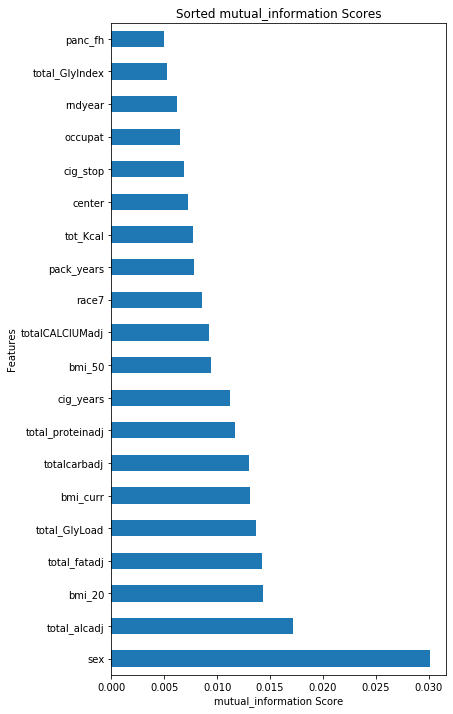

In [42]:
#Run Mutual Information for each CV------------------------------------------------------------------------------
algorithm = 'mutual_information'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    featureNameRanks = [] #list of feature name ranks for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_mi(xTrainList[i],yTrainList[i], i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    #cv_output_name = data_name+'_clean_imp_CV_'+partition_method
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('Mutual Information Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## MultiSURF


MultiSURF Run Time: 816.1548626422882


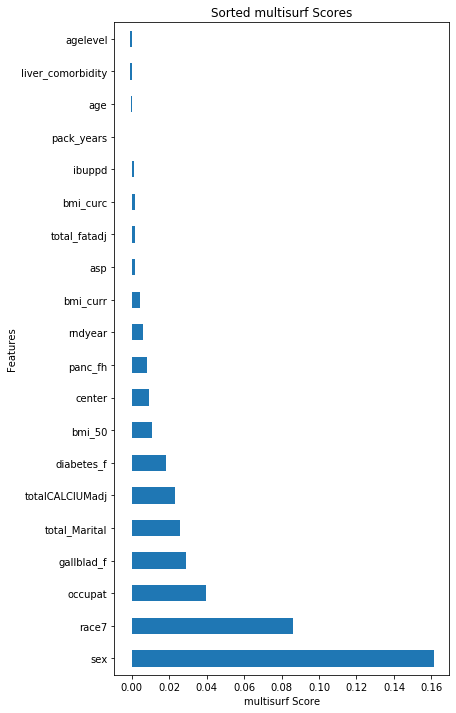

In [43]:
#Run MultiSURF for each CV------------------------------------------------------------------------------
algorithm = 'multisurf'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #If training set is large MultiSURF will run very slowly - quadradic time complexity with # instances (so use subset)
        tempData = pd.concat([pd.DataFrame(yTrainList[i]),pd.DataFrame(xTrainList[i])], axis=1, sort=False)
        if len(tempData) < instanceSubset:
            dataSample = tempData.sample(n=len(tempData), axis = 0)
        else:
            dataSample = tempData.sample(n=instanceSubset, axis = 0)

        xTrain = dataSample.iloc[:, 1:].values
        yTrain = dataSample.iloc[:, 0].values
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_multisurf(xTrain,yTrain, i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('MultiSURF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

---
# Feature Selection

## Identify union of 'interesting' features from different algorithms
- Operates no matter how many feature selection methods are being applied
- But assumes that all methods have larger scores as being more informative

In [44]:
cv_Selected_List = selectFeatures(algorithms, cv_partitions, selectedFeatureLists, maxFeaturesToKeep,metaFeatureRanks)

### Report counts of 'interesting' features identified by each algorithm

In [45]:
print('Original feature count: '+str(len(ordered_feature_names)))

for each in algorithms:
    print(each)
    for cv in selectedFeatureLists[each]:
        print(len(cv))
    
print("Selected Counts")
for each in cv_Selected_List:
    print(len(each))

Original feature count: 37
mutual_information
29
30
29
27
28
28
28
27
26
23
multisurf
16
17
18
17
17
17
18
21
17
20
Selected Counts
32
33
31
31
31
33
31
32
31
33


## Generate Filtered Datasets (Save as new .txt files)
- These datasets included only the selected features for each respective partition
- Note that the feature order from the original datasets is no longer preserved in these datasets

In [46]:
if filterPoorFeatures:
    genFilteredDatasets(cv_Selected_List, outcomeLabel, instLabel,cv_partitions,cv_data_folder,data_name)
    data_name = data_name +'_FS'

## Generate Filtered MultiSURF Files (Save as new .txt files)

In [47]:
if 'multisurf' in algorithms: #This method is only meant for working with MultiSURF scores
    if filterPoorFeatures:
        for i in range(cv_partitions):
            tempDict = scoreDictSet[i]

            #create new dictionary with only selected features
            scoreDict = {}
            for j in cv_Selected_List[i]:
                scoreDict[j] = tempDict[j]
            
            filename = output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
            sort_save_fs_fi_scores(scoreDict, 'multisurf', filename)

---
# Load, Check, and Prepare Filtered CV Datasets for ML
- If user opted not to filter datasets then the code below will simply reload the original CV datasets again.

## Load CV Partition Datasets (Filtered Datasets)

In [48]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)

    #Load testing partition
    testset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Training Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Training Partitions: 10


## CV partition data cleaning (Filtered Datasets)

In [49]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [50]:
global_ordered_features = [] #Holds the new order of features in the FS CV datasets
for i in range(cv_partitions):
    cv_ordered_features = list(trainList[i])
    cv_ordered_features.remove(outcomeLabel)
    #print(cv_ordered_features)
    global_ordered_features.append(cv_ordered_features)

## Format data for Scikit learn (filtered datasets)

In [51]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


---
# Machine Learning Modeling
ML algorithms are run one after the other below. Within each we conduct a hyperparameter sweep, train a best model and evaluate it indendently within each CV training/testing partition. 
- All standard classification metrics are computed for the resulting models as well as an ROC curve and precision/recall curve

## Run Logistic Regression

Running logistic_regression
Best trial:
  Value:  0.6805437657740011
  Params: 
    penalty: l2
    dual: False
    C: 297.3042389323509
    solver: saga
    class_weight: balanced
    max_iter: 51.70191786366991
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6821589533179778
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6820944540667103
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6775885398812852
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6885554047064909
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6812377090587619
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6853740806225606
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6920096728830515
  Params: 
    penalty: l2
    dual: False
    C: 297.3042389323509
    solver: saga
    class_weight: balanced
    max_iter: 51.70191786366991
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6935584317109792
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6933000337781626
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1


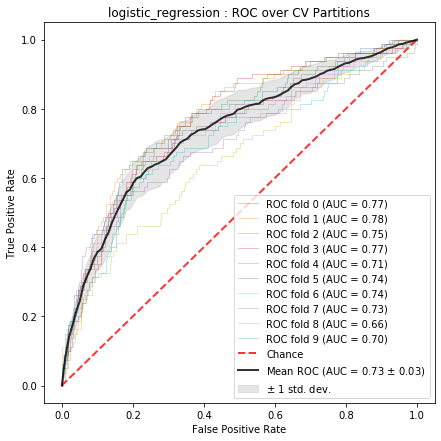

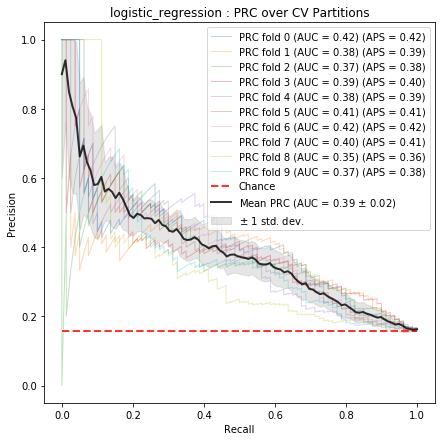

Avg. Model Balanced Accuracy = 0.6918603295928877 (std. dev. = 0.03393140682441522)
Avg. Model Accuracy = 0.7445945529488809 (std. dev. = 0.018294609351892716)
Avg. Model F1-Score = 0.430321724799271 (std. dev. = 0.03955307083657758)
Avg. Model Recall = 0.615 (std. dev. = 0.060673305497557985)
Avg. Model Specificity = 0.7687206591857755 (std. dev. = 0.014461258942071111)
Avg. Model Precision = 0.33114350437621776 (std. dev. = 0.030383075062421796)
Avg. Model True Positives = 49.2 (std. dev. = 4.853864439804639)
Avg. Model True Negatives = 330.4 (std. dev. = 6.421837743200928)
Avg. Model False Positives = 99.4 (std. dev. = 6.151422599691879)
Avg. Model False Negatives = 30.8 (std. dev. = 4.853864439804639)
Avg. ROC AUC = 0.7347360410906922 (std. dev. = 0.0333911860456426)
Avg. PRC AUC = 0.38924576587478005 (std. dev. = 0.020151449820513426)
Avg. PRC Precision Score = 0.39442160447141494 (std. dev. = 0.019788275597512128)

---Feature Importances---



Names    Scores
36                  sex  0.058308
31                race7  0.024948
0              cig_stat  0.009084
10       total_GlyIndex  0.005974
35              rndyear  0.005306
3            pack_years  0.005190
34               center  0.005130
6              tot_Kcal  0.004492
17           diabetes_f  0.004448
1              cig_stop  0.004172
28                  age  0.004070
33              occupat  0.003198
26           gallblad_f  0.003197
14      totalCALCIUMadj  0.002457
8      total_proteinadj  0.002384
19            fh_cancer  0.002267
20               bmi_20  0.001875
11        total_GlyLoad  0.001715
9   totalfolate_NDSRadj  0.001599
22                  asp  0.001439

Logistic Regression Run Time: 319.880393743515


In [52]:
algorithm = 'logistic_regression'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Logistic Regression Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Decision Tree

Running decision_tree
Best trial:
  Value:  0.6832443023155582
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 4
    min_samples_split: 14
    min_samples_leaf: 25
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6748543128800044
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 12
    min_samples_split: 31
    min_samples_leaf: 40
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6661626754309472
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 27
    min_samples_split: 20
    min_samples_leaf: 42
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6677146667388336
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 26
    min_samples_split: 29
    min_samples_leaf: 45
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.670084262

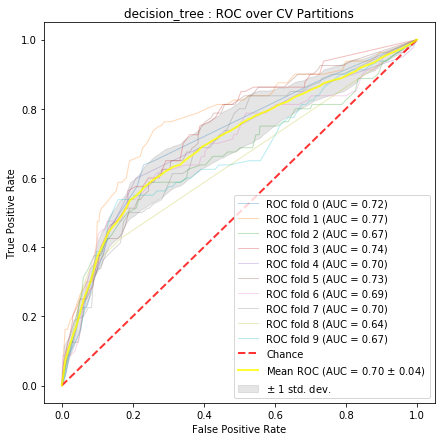

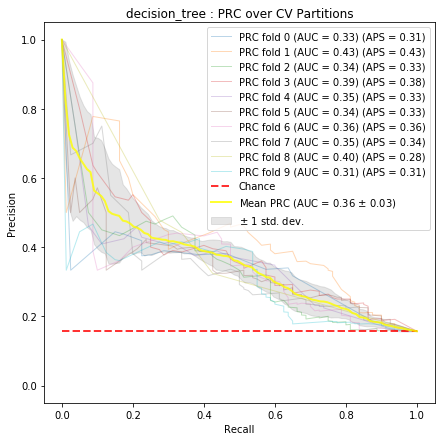

Avg. Model Balanced Accuracy = 0.6637114097143166 (std. dev. = 0.03600850898146493)
Avg. Model Accuracy = 0.7065599599368235 (std. dev. = 0.04074504759821351)
Avg. Model F1-Score = 0.39215056089701095 (std. dev. = 0.040112093977132106)
Avg. Model Recall = 0.6012500000000001 (std. dev. = 0.08032161913208673)
Avg. Model Specificity = 0.7261728194286333 (std. dev. = 0.05372539841975268)
Avg. Model Precision = 0.29400525154997675 (std. dev. = 0.03681844888483504)
Avg. Model True Positives = 48.1 (std. dev. = 6.4257295305669375)
Avg. Model True Negatives = 312.1 (std. dev. = 22.958440713602478)
Avg. Model False Positives = 117.7 (std. dev. = 23.12595943955623)
Avg. Model False Negatives = 31.9 (std. dev. = 6.4257295305669375)
Avg. ROC AUC = 0.7010642889087657 (std. dev. = 0.03543327951410935)
Avg. PRC AUC = 0.3598934132700361 (std. dev. = 0.033722015974013475)
Avg. PRC Precision Score = 0.3389127027606725 (std. dev. = 0.039837107399187166)

---Feature Importances---



Names    Scores
36               sex  0.400340
31             race7  0.140846
1           cig_stop  0.044312
6           tot_Kcal  0.041669
7       totalcarbadj  0.041512
4       total_alcadj  0.031420
11     total_GlyLoad  0.024616
35           rndyear  0.024481
2          cig_years  0.021400
21            bmi_50  0.017867
20            bmi_20  0.017854
5       total_fatadj  0.016600
3         pack_years  0.016093
33           occupat  0.015965
8   total_proteinadj  0.015868
34            center  0.013082
16          bmi_curr  0.011380
28               age  0.011272
22               asp  0.010915
10    total_GlyIndex  0.010565

Decision Tree Run Time: 289.873348236084


In [53]:
algorithm = 'decision_tree'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Decision Tree Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Random Forest

Running random_forest
Best trial:
  Value:  0.692521845550604
  Params: 
    n_estimators: 570
    criterion: gini
    max_depth: 15
    min_samples_split: 13
    min_samples_leaf: 44
    max_features: None
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.69491072341398
  Params: 
    n_estimators: 268
    criterion: entropy
    max_depth: 28
    min_samples_split: 41
    min_samples_leaf: 50
    max_features: None
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.695154474955046
  Params: 
    n_estimators: 676
    criterion: gini
    max_depth: 25
    min_samples_split: 26
    min_samples_leaf: 42
    max_features: None
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.6969803124429932
  Params: 
    n_estimators: 287
    criterion: gini
    max_depth

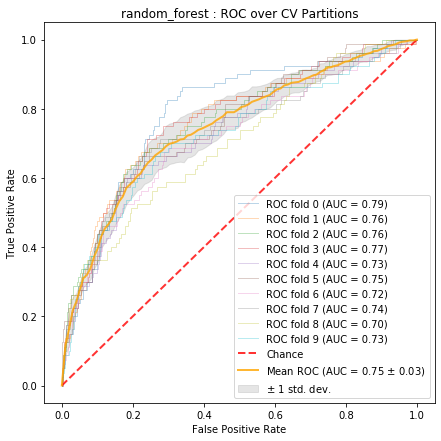

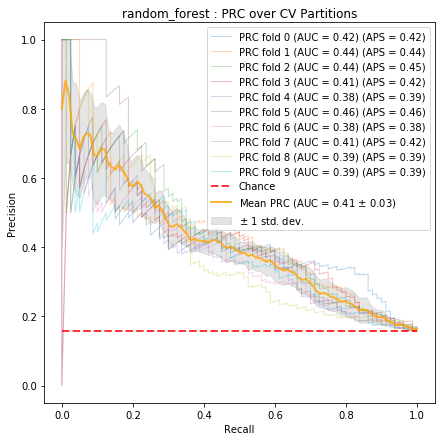

Avg. Model Balanced Accuracy = 0.6923546172819428 (std. dev. = 0.023772397715544027)
Avg. Model Accuracy = 0.7840248083516315 (std. dev. = 0.01222686941238603)
Avg. Model F1-Score = 0.4477402704889412 (std. dev. = 0.030408940622385788)
Avg. Model Recall = 0.55875 (std. dev. = 0.0490694660659763)
Avg. Model Specificity = 0.8259592345638858 (std. dev. = 0.013721397122000097)
Avg. Model Precision = 0.37416238788698586 (std. dev. = 0.0243412256663462)
Avg. Model True Positives = 44.7 (std. dev. = 3.9255572852781047)
Avg. Model True Negatives = 355.0 (std. dev. = 6.06630035524124)
Avg. Model False Positives = 74.8 (std. dev. = 5.861740355901138)
Avg. Model False Negatives = 35.3 (std. dev. = 3.9255572852781047)
Avg. ROC AUC = 0.7459429649807556 (std. dev. = 0.025159040398715034)
Avg. PRC AUC = 0.4114261016952946 (std. dev. = 0.02720133267364515)
Avg. PRC Precision Score = 0.41722488099111266 (std. dev. = 0.026169668145995105)

---Feature Importances---



Names    Scores
36                  sex  0.245391
31                race7  0.080396
6              tot_Kcal  0.076119
11        total_GlyLoad  0.069537
7          totalcarbadj  0.058416
4          total_alcadj  0.046205
5          total_fatadj  0.039020
1              cig_stop  0.037979
8      total_proteinadj  0.036809
10       total_GlyIndex  0.032644
14      totalCALCIUMadj  0.032108
2             cig_years  0.028783
20               bmi_20  0.028415
21               bmi_50  0.023109
16             bmi_curr  0.022268
9   totalfolate_NDSRadj  0.020821
3            pack_years  0.019851
28                  age  0.017947
12         totalcholadj  0.016423
34               center  0.014953

Random Forest Run Time: 2953.918089389801


In [54]:
algorithm = 'random_forest'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Random Forest Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Naive Bayes

Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes


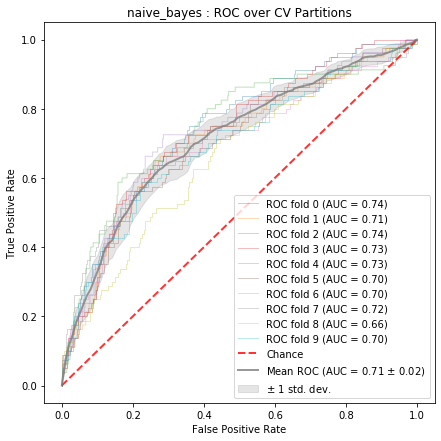

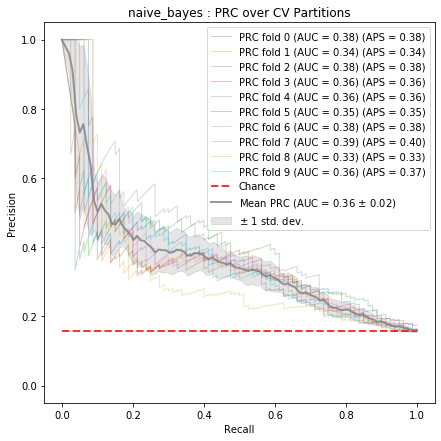

Avg. Model Balanced Accuracy = 0.6219814197430475 (std. dev. = 0.02366316493970033)
Avg. Model Accuracy = 0.8103147270696096 (std. dev. = 0.01148712933045523)
Avg. Model F1-Score = 0.3644182572728304 (std. dev. = 0.04170801145915741)
Avg. Model Recall = 0.3475 (std. dev. = 0.04636809247747852)
Avg. Model Specificity = 0.8964628394860952 (std. dev. = 0.01072707624086819)
Avg. Model Precision = 0.38458511229163594 (std. dev. = 0.04266328268698257)
Avg. Model True Positives = 27.8 (std. dev. = 3.7094473981982814)
Avg. Model True Negatives = 385.3 (std. dev. = 4.648655719667783)
Avg. Model False Positives = 44.5 (std. dev. = 4.6097722286464435)
Avg. Model False Negatives = 52.2 (std. dev. = 3.709447398198281)
Avg. ROC AUC = 0.7127918563994146 (std. dev. = 0.024828501928549733)
Avg. PRC AUC = 0.3620967395834104 (std. dev. = 0.01942206495768187)
Avg. PRC Precision Score = 0.36449080344403534 (std. dev. = 0.020246721426990934)

---Feature Importances---



Names    Scores
36               sex  0.042638
31             race7  0.011701
14   totalCALCIUMadj  0.007573
26        gallblad_f  0.006642
17        diabetes_f  0.006017
11     total_GlyLoad  0.005291
10    total_GlyIndex  0.005189
18           panc_fh  0.004302
6           tot_Kcal  0.003953
1           cig_stop  0.003706
21            bmi_50  0.003169
8   total_proteinadj  0.002892
16          bmi_curr  0.002384
2          cig_years  0.002340
20            bmi_20  0.002268
28               age  0.002224
15          bmi_curc  0.002108
34            center  0.002108
12      totalcholadj  0.002034
5       total_fatadj  0.001875

Naive Bayes Run Time: 2.8473501205444336


In [55]:
algorithm = 'naive_bayes'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('Naive Bayes Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XGBoost

Running XGB
Best trial:
  Value:  0.6920437767995141
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.005577568475950612
    alpha: 4.156032088243323e-08
    eta: 9.671271918291968e-08
    gamma: 0.505918347503813
    max_depth: 2
    grow_policy: lossguide
    n_estimators: 84
    min_samples_split: 4
    min_samples_leaf: 28
    subsample: 0.5994130693890467
    min_child_weight: 9.95602810397567
    colsample_bytree: 0.9606209584532325
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6910696727226803
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.001634209247823498
    alpha: 1.0061828335768546e-08
    eta: 2.40050238194574e-08
    gamma: 0.34402668839396605
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 193
    min_samples_split: 2
    min_samples_leaf: 32
    subsample: 0.592740998399903
    min_child_weight: 9.38051615917488
    colsample_bytree: 0.9422746629051277
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.7006815521115862
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.001634209247823498
    alpha: 1.0061828335768546e-08
    eta: 2.40050238194574e-08
    gamma: 0.34402668839396605
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 193
    min_samples_split: 2
    min_samples_leaf: 32
    subsample: 0.592740998399903
    min_child_weight: 9.38051615917488
    colsample_bytree: 0.9422746629051277
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6942397583007077
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.004432544694960653
    alpha: 7.459269117379215e-07
    eta: 1.0318134576016894e-05
    gamma: 0.2275270685798271
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 305
    min_samples_split: 2
    min_samples_leaf: 41
    subsample: 0.6746774498891667
    min_child_weight: 6.006401214366354
    colsample_bytree: 0.35917789627401003
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.7030419390469547
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.00098645407366245
    alpha: 2.568633876025397e-07
    eta: 5.603071257445277e-08
    gamma: 0.8833123815288352
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 212
    min_samples_split: 22
    min_samples_leaf: 41
    subsample: 0.5763623003365623
    min_child_weight: 6.736915403603849
    colsample_bytree: 0.9736480743288298
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6974388359664263
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 1.5407245337449087e-05
    alpha: 1.0478258226299112e-08
    eta: 2.5044886950425385e-06
    gamma: 0.00019861221143288932
    max_depth: 1
    grow_policy: depthwise
    n_estimators: 519
    min_samples_split: 5
    min_samples_leaf: 31
    subsample: 0.7649500498088738
    min_child_weight: 5.506285653979479
    colsample_bytree: 0.3762932467738872
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6971495415391216
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.020784162236939494
    alpha: 7.492967069069548e-08
    eta: 5.987146143096858e-05
    gamma: 0.4833833631957377
    max_depth: 1
    grow_policy: depthwise
    n_estimators: 124
    min_samples_split: 28
    min_samples_leaf: 7
    subsample: 0.5162819217479091
    min_child_weight: 4.939319317379087
    colsample_bytree: 0.5760472563016541
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.7019760475740865
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.004421043486292511
    alpha: 1.3986275604584254e-07
    eta: 4.6329925034898753e-07
    gamma: 0.035396636592415424
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 191
    min_samples_split: 3
    min_samples_leaf: 3
    subsample: 0.6968326032941005
    min_child_weight: 6.2616035022649426
    colsample_bytree: 0.44462037731926396
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.7118101912826279
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0013228431985953819
    alpha: 3.565741530847459e-05
    eta: 2.2462345027410463e-08
    gamma: 0.8702376248175365
    max_depth: 2
    grow_policy: lossguide
    n_estimators: 80
    min_samples_split: 45
    min_samples_leaf: 31
    subsample: 0.5869069513619387
    min_child_weight: 5.377894840203112
    colsample_bytree: 0.7794703093057891
    scale_pos_weight: 5.373611111111111



Running XGB
Best trial:
  Value:  0.7047814893663938
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0012904053930122103
    alpha: 5.289225999545794e-08
    eta: 1.6067132140363338e-07
    gamma: 0.4915134902795285
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 181
    min_samples_split: 3
    min_samples_leaf: 32
    subsample: 0.5299770669957331
    min_child_weight: 9.918033834618516
    colsample_bytree: 0.9695761659394593
    scale_pos_weight: 5.373611111111111


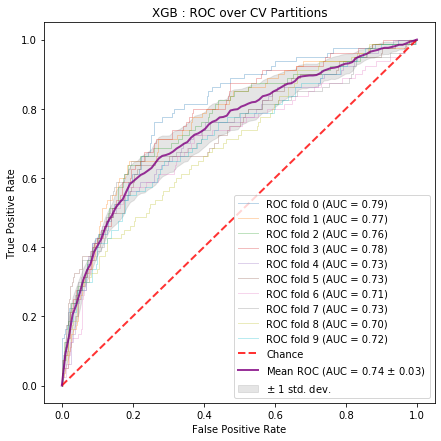

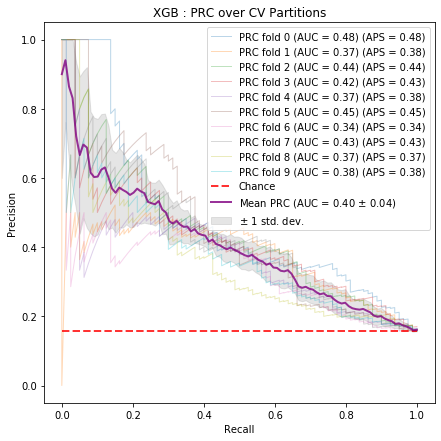

Avg. Model Balanced Accuracy = 0.6947735404130753 (std. dev. = 0.02529101923178567)
Avg. Model Accuracy = 0.756367733733965 (std. dev. = 0.017554914161440924)
Avg. Model F1-Score = 0.43802187162753625 (std. dev. = 0.030876310712453385)
Avg. Model Recall = 0.6050000000000001 (std. dev. = 0.05006246098625197)
Avg. Model Specificity = 0.7845470808261507 (std. dev. = 0.020326976787656)
Avg. Model Precision = 0.3439422875385083 (std. dev. = 0.026185948097597476)
Avg. Model True Positives = 48.4 (std. dev. = 4.004996878900157)
Avg. Model True Negatives = 337.2 (std. dev. = 8.806815542521598)
Avg. Model False Positives = 92.6 (std. dev. = 8.720091742636656)
Avg. Model False Negatives = 31.6 (std. dev. = 4.004996878900157)
Avg. ROC AUC = 0.7419257264053776 (std. dev. = 0.029869041882556863)
Avg. PRC AUC = 0.4045362917077819 (std. dev. = 0.04218541335200982)
Avg. PRC Precision Score = 0.40961377366746543 (std. dev. = 0.04104163034593309)

---Feature Importances---



Names    Scores
36               sex  0.045184
31             race7  0.017108
11     total_GlyLoad  0.007296
2          cig_years  0.007064
7       totalcarbadj  0.006047
8   total_proteinadj  0.006003
26        gallblad_f  0.005785
35           rndyear  0.005422
10    total_GlyIndex  0.005160
33           occupat  0.004913
6           tot_Kcal  0.004492
1           cig_stop  0.004286
20            bmi_20  0.004013
34            center  0.003940
16          bmi_curr  0.003780
3         pack_years  0.003749
5       total_fatadj  0.003706
17        diabetes_f  0.003547
15          bmi_curc  0.003242
28               age  0.002762

XGBoost Run Time: 3224.3879704475403


In [56]:
algorithm = 'XGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('XGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LGBoost

Running LGB
Best trial:
  Value:  0.6969700887854495
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 37
    max_depth: 1
    lambda_l1: 6.290250814691986e-07
    lambda_l2: 0.008216060379070635
    feature_fraction: 0.5457455987860588
    bagging_fraction: 0.9993803338333725
    bagging_freq: 3
    min_child_samples: 95
    n_estimators: 365
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6957229403840487
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 10
    lambda_l1: 0.0002337328661326072
    lambda_l2: 0.006357715206107445
    feature_fraction: 0.4901250946726333
    bagging_fraction: 0.814198348761447
    bagging_freq: 3
    min_child_samples: 67
    n_estimators: 163
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6995974058972463
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 40
    max_depth: 1
    lambda_l1: 0.005746900856353005
    lambda_l2: 8.450907637753986
    feature_fraction: 0.5292801116463797
    bagging_fraction: 0.47966327531318353
    bagging_freq: 6
    min_child_samples: 57
    n_estimators: 121
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6945776025723523
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 7
    max_depth: 1
    lambda_l1: 0.7468623018734883
    lambda_l2: 0.1678118933282337
    feature_fraction: 0.49421428254914007
    bagging_fraction: 0.9278664079698118
    bagging_freq: 4
    min_child_samples: 62
    n_estimators: 489
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.7042692289958965
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 27
    lambda_l1: 7.283568812628957e-05
    lambda_l2: 0.0008346823702130479
    feature_fraction: 0.6669771654353479
    bagging_fraction: 0.6672329790597465
    bagging_freq: 4
    min_child_samples: 36
    n_estimators: 138
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.7003319681743555
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 172
    max_depth: 1
    lambda_l1: 1.9852360253692354e-06
    lambda_l2: 0.46952669946485875
    feature_fraction: 0.45288658761304534
    bagging_fraction: 0.5732318816436056
    bagging_freq: 3
    min_child_samples: 28
    n_estimators: 152
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6927537697231395
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 165
    max_depth: 1
    lambda_l1: 1.0295189036924568e-06
    lambda_l2: 0.006869383739767032
    feature_fraction: 0.924870243707625
    bagging_fraction: 0.9766677956387994
    bagging_freq: 6
    min_child_samples: 14
    n_estimators: 648
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.7049637736722776
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 1
    lambda_l1: 2.221373759831745e-07
    lambda_l2: 0.0005369640762544691
    feature_fraction: 0.659198917319502
    bagging_fraction: 0.6817785349791494
    bagging_freq: 6
    min_child_samples: 44
    n_estimators: 172
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.7054299899968527
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 15
    lambda_l1: 6.5462484242751
    lambda_l2: 4.7166471841000925
    feature_fraction: 0.6011079308061669
    bagging_fraction: 0.6078378013890661
    bagging_freq: 2
    min_child_samples: 13
    n_estimators: 189
    scale_pos_weight: 5.373611111111111



Running LGB
Best trial:
  Value:  0.7029563535020037
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 68
    max_depth: 1
    lambda_l1: 0.009547005010164126
    lambda_l2: 0.0008592727023063755
    feature_fraction: 0.6784743096367002
    bagging_fraction: 0.5040323521903345
    bagging_freq: 5
    min_child_samples: 22
    n_estimators: 339
    scale_pos_weight: 5.373611111111111


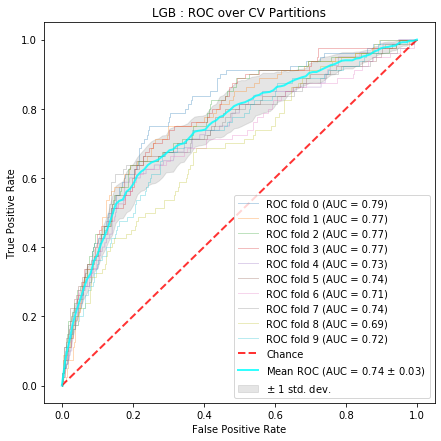

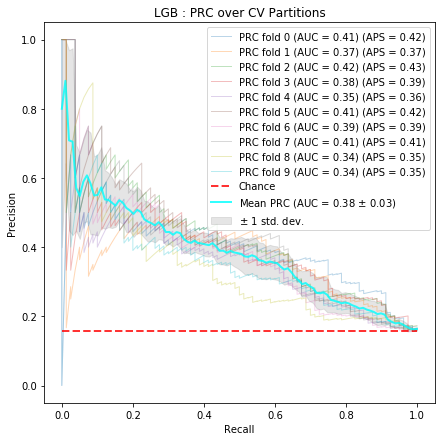

Avg. Model Balanced Accuracy = 0.7001928836667208 (std. dev. = 0.031589965653009124)
Avg. Model Accuracy = 0.7595015216302631 (std. dev. = 0.018469811692814232)
Avg. Model F1-Score = 0.44456903688358923 (std. dev. = 0.03692639938933246)
Avg. Model Recall = 0.61375 (std. dev. = 0.062362348416332106)
Avg. Model Specificity = 0.7866357673334419 (std. dev. = 0.019977351493175536)
Avg. Model Precision = 0.3491730261089307 (std. dev. = 0.02995455537944215)
Avg. Model True Positives = 49.1 (std. dev. = 4.988987873306568)
Avg. Model True Negatives = 338.1 (std. dev. = 8.74585616163449)
Avg. Model False Positives = 91.7 (std. dev. = 8.544588931013593)
Avg. Model False Negatives = 30.9 (std. dev. = 4.988987873306568)
Avg. ROC AUC = 0.7430091105599826 (std. dev. = 0.03074954504089867)
Avg. PRC AUC = 0.3813260570031921 (std. dev. = 0.029874751288294397)
Avg. PRC Precision Score = 0.3875671184161024 (std. dev. = 0.02862417447615214)

---Feature Importances---



Names    Scores
36               sex  0.052105
31             race7  0.024581
8   total_proteinadj  0.012485
6           tot_Kcal  0.011544
34            center  0.009754
10    total_GlyIndex  0.009203
17        diabetes_f  0.008998
11     total_GlyLoad  0.008968
4       total_alcadj  0.008128
5       total_fatadj  0.007124
3         pack_years  0.007021
33           occupat  0.006744
25            ibuppd  0.006469
1           cig_stop  0.006468
14   totalCALCIUMadj  0.006468
20            bmi_20  0.006076
26        gallblad_f  0.006046
35           rndyear  0.006004
7       totalcarbadj  0.005772
2          cig_years  0.005655

LGBoost Run Time: 1342.3442733287811


In [57]:
algorithm = 'LGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('LGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run SVM

Running SVM
Best trial:
  Value:  0.578333012591136
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5872105301668059
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5905558587571641
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6773068630811698
  Params: 
    kernel: rbf
    C: 0.17073967431528117
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5852269025525065
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5913508107761359
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5839529671660222
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5738077411129353
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5837862438683113
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.581769213961106
  Params: 
    kernel: rbf
    C: 153.52246941973468
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced


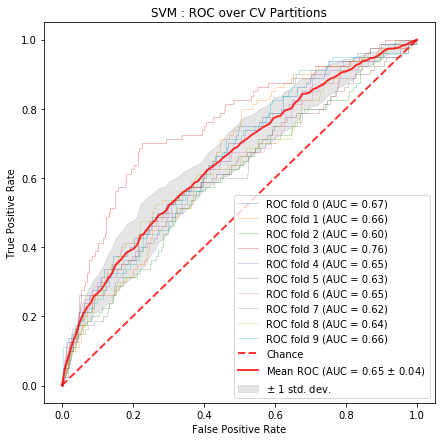

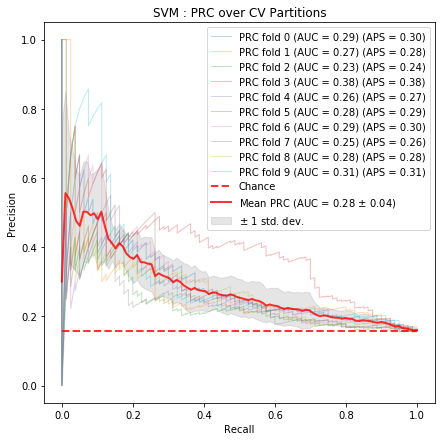

Avg. Model Balanced Accuracy = 0.5909892529950669 (std. dev. = 0.04135700278007347)
Avg. Model Accuracy = 0.7889356292615278 (std. dev. = 0.008224918134422644)
Avg. Model F1-Score = 0.3042822562826307 (std. dev. = 0.0629226823162266)
Avg. Model Recall = 0.30250000000000005 (std. dev. = 0.10043654713300332)
Avg. Model Specificity = 0.879478505990134 (std. dev. = 0.020726631293553826)
Avg. Model Precision = 0.31295494362859133 (std. dev. = 0.038695345376801395)
Avg. Model True Positives = 24.2 (std. dev. = 8.034923770640267)
Avg. Model True Negatives = 378.0 (std. dev. = 8.921883209278185)
Avg. Model False Positives = 51.8 (std. dev. = 8.908422980528034)
Avg. Model False Negatives = 55.8 (std. dev. = 8.034923770640267)
Avg. ROC AUC = 0.6523722082181385 (std. dev. = 0.0395141204005855)
Avg. PRC AUC = 0.28314994931978066 (std. dev. = 0.03690260799789577)
Avg. PRC Precision Score = 0.29093063297797883 (std. dev. = 0.0373877333164587)

---Feature Importances---



Names    Scores
36                  sex  0.024057
31                race7  0.014679
33              occupat  0.009902
21               bmi_50  0.007498
6              tot_Kcal  0.006323
26           gallblad_f  0.005902
17           diabetes_f  0.005552
34               center  0.005538
9   totalfolate_NDSRadj  0.005262
14      totalCALCIUMadj  0.005147
0              cig_stat  0.004755
10       total_GlyIndex  0.004665
30               educat  0.004578
32        total_Marital  0.004565
8      total_proteinadj  0.004449
5          total_fatadj  0.004375
11        total_GlyLoad  0.004099
35              rndyear  0.004084
4          total_alcadj  0.003940
12         totalcholadj  0.003794

SVM Run Time: 6404.389785051346


In [58]:
algorithm = 'SVM'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('SVM Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ANN

Running ANN
Best trial:
  Value:  0.5925408770895854
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.28395456030937816
    solver: adam
    batch_size: auto
    alpha: 0.0026534556728441063
    max_iter: 200
    n_layers: 1
    n_units_l0: 44



Running ANN
Best trial:
  Value:  0.6040796152296414
  Params: 
    activation: relu
    learning_rate: constant
    momentum: 0.2506638180476375
    solver: adam
    batch_size: auto
    alpha: 0.003029183724109036
    max_iter: 200
    n_layers: 3
    n_units_l0: 82
    n_units_l1: 75
    n_units_l2: 41



Running ANN
Best trial:
  Value:  0.5981426771549364
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.1187858598732
    solver: adam
    batch_size: auto
    alpha: 0.00010967185317481866
    max_iter: 200
    n_layers: 1
    n_units_l0: 99



Running ANN
Best trial:
  Value:  0.5978214839137764
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.30077116835489737
    solver: adam
    batch_size: auto
    alpha: 0.03536212491132829
    max_iter: 200
    n_layers: 1
    n_units_l0: 99



Running ANN
Best trial:
  Value:  0.6030194369771652
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.5578231723074312
    solver: adam
    batch_size: auto
    alpha: 0.024442442983323574
    max_iter: 200
    n_layers: 1
    n_units_l0: 100



Running ANN
Best trial:
  Value:  0.6053420114144129
  Params: 
    activation: relu
    learning_rate: adaptive
    momentum: 0.3656630830178088
    solver: adam
    batch_size: auto
    alpha: 0.0010858097896334585
    max_iter: 200
    n_layers: 2
    n_units_l0: 92
    n_units_l1: 68



Running ANN
Best trial:
  Value:  0.598790676625712
  Params: 
    activation: relu
    learning_rate: constant
    momentum: 0.30148564050114635
    solver: adam
    batch_size: auto
    alpha: 0.00016665332125521037
    max_iter: 200
    n_layers: 1
    n_units_l0: 53



Running ANN
Best trial:
  Value:  0.5931523670774171
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.26987128854262094
    solver: adam
    batch_size: auto
    alpha: 0.04763753013193291
    max_iter: 200
    n_layers: 1
    n_units_l0: 76



Running ANN
Best trial:
  Value:  0.59643951102852
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.33447303425982616
    solver: adam
    batch_size: auto
    alpha: 0.000397854357139452
    max_iter: 200
    n_layers: 1
    n_units_l0: 38



Running ANN
Best trial:
  Value:  0.6040939483965898
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.29940476265370447
    solver: adam
    batch_size: auto
    alpha: 0.0306464375658965
    max_iter: 200
    n_layers: 1
    n_units_l0: 78


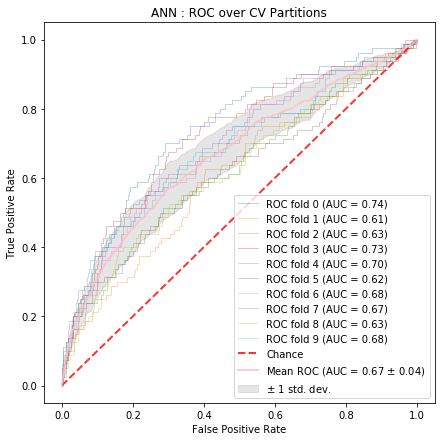

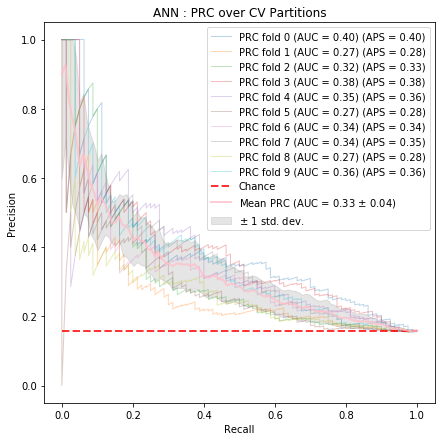

Avg. Model Balanced Accuracy = 0.5800007114978045 (std. dev. = 0.013709632983299766)
Avg. Model Accuracy = 0.8244416194768673 (std. dev. = 0.017164372200186864)
Avg. Model F1-Score = 0.28658970833754543 (std. dev. = 0.028221944752918126)
Avg. Model Recall = 0.22374999999999998 (std. dev. = 0.02197299478905869)
Avg. Model Specificity = 0.9362514229956089 (std. dev. = 0.0206733105210882)
Avg. Model Precision = 0.4081288501409836 (std. dev. = 0.07510828563354575)
Avg. Model True Positives = 17.9 (std. dev. = 1.7578395831246947)
Avg. Model True Negatives = 402.4 (std. dev. = 8.85663593019381)
Avg. Model False Positives = 27.4 (std. dev. = 8.890444308357148)
Avg. Model False Negatives = 62.1 (std. dev. = 1.7578395831246947)
Avg. ROC AUC = 0.6681471106412966 (std. dev. = 0.04400760868886138)
Avg. PRC AUC = 0.3291845905888402 (std. dev. = 0.04262233708176593)
Avg. PRC Precision Score = 0.3343383206815388 (std. dev. = 0.041888718103912585)

---Feature Importances---



Names    Scores
36                  sex  0.014866
31                race7  0.014491
8      total_proteinadj  0.008039
3            pack_years  0.007690
28                  age  0.007225
35              rndyear  0.006334
18              panc_fh  0.005552
14      totalCALCIUMadj  0.005437
29             agelevel  0.005436
5          total_fatadj  0.004897
12         totalcholadj  0.004738
21               bmi_50  0.004683
34               center  0.004608
2             cig_years  0.004493
0              cig_stat  0.004478
25               ibuppd  0.004289
26           gallblad_f  0.004099
9   totalfolate_NDSRadj  0.003823
6              tot_Kcal  0.003590
32        total_Marital  0.003559

ANN Run Time: 3951.4822294712067


In [59]:
algorithm = 'ANN'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('ANN Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LCS

In [60]:
def makeConfigFile(train_dataset,test_dataset,outpath,external_ek_file,iterations,popsize,configfile,outcomelabel,instancelabel,discthresh):
    """ Construct Configuration File for CV Analysis """
    configFile = open(configfile,'w')
    
    #Write to Config File#############################################################################################################
    configFile.write('offlineData=1# \n')
    configFile.write('trainFile='+str(train_dataset)+'# \n')
    configFile.write('testFile='+str(test_dataset)+'# \n')
    configFile.write('internalCrossValidation=0# \n')
    
    configFile.write('outFileName='+str(outpath)+'# \n')
    configFile.write('randomSeed=1# \n')
    configFile.write('labelInstanceID='+str(instancelabel)+'# \n')
    configFile.write('labelPhenotype='+str(outcomelabel)+'# \n')
    configFile.write('discreteAttributeLimit='+str(discthresh)+'# \n')
    configFile.write('labelMissingData=NA# \n')
    configFile.write('outputSummary=1# \n')
    configFile.write('outputPopulation=1# \n')
    configFile.write('outputAttCoOccur=1# \n')
    configFile.write('outputTestPredictions=1# \n')  
    configFile.write('maxAttsCoOccur=50# \n')
        
    configFile.write('trackingFrequency=0# \n')
    configFile.write('learningIterations='+str(iterations)+'# \n')
    
    configFile.write('N='+str(popsize)+'# \n') 
    configFile.write('nu=1# \n')
    configFile.write('chi=0.8# \n')
    configFile.write('upsilon=0.04# \n')
    configFile.write('theta_GA=25# \n')
    configFile.write('theta_del=20# \n')   
    configFile.write('theta_sub=20# \n')    
    configFile.write('acc_sub=0.99# \n')    
    configFile.write('beta=0.2# \n')         
    configFile.write('delta=0.1# \n')     
    configFile.write('init_fit=0.01# \n')
    configFile.write('fitnessReduction=0.1# \n')
    configFile.write('theta_sel=0.5# \n')
    configFile.write('RSL_Override=0# \n')

    configFile.write('doSubsumption=1# \n')
    configFile.write('selectionMethod=tournament# \n')
    
    configFile.write('doAttributeTracking=1# \n')
    configFile.write('doAttributeFeedback=1# \n')
    
    configFile.write('useExpertKnowledge=1# \n')
    configFile.write('external_EK_Generation='+str(external_ek_file)+'# \n')
    configFile.write('outEKFileName=None# \n')
    
    configFile.write('filterAlgorithm=None# \n')
    configFile.write('turfPercent=0.2# \n')
    configFile.write('reliefNeighbors=10# \n')
    configFile.write('reliefSampleFraction=1# \n')
    configFile.write('onlyEKScores=0# \n')
    
    configFile.write('doRuleCompaction=1# \n')
    configFile.write('onlyRC=0# \n')
    configFile.write('ruleCompactionMethod=QRF# \n')
    
    configFile.write('doPopulationReboot=0# \n')
    configFile.write('popRebootIteration=0# \n')
    
    configFile.close()

### Generate LCS Configuration Files (needed to pass all run/hyperparamters)

In [61]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    # Generate LCS configuration files (needed to pass all run/hyper parameters to LCS)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        trainFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
        testFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
        ekFile = wd_path+output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
        configfile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        outFold = wd_path+lcs_folder+'/'

        makeConfigFile(trainFile,testFile,outFold,ekFile,iterations,popsize,configfile,outcomeLabel,instLabel,categoricalCutoff)

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    #Use Python Magic to run Exstracs from command line
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch'+'/'+'exstracs_main.py'
        configFile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        %run {lcs_path} {configFile}

----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj/cv_datasets/Epi_DietAdj_20180710_clean_scale_imp_CV_S_FS_0_Train.txt
DataManagement: Instance ID Column location = 1
DataManagement: Phenotype Column Location = 0
DataManagement: Number of Attributes = 32
DataManagement: Number of Instances = 4588
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj/cv_datasets/Epi_DietAdj_20180710_clean_scale_imp_CV_S_FS_0_Test.txt
DataManagement: Number of Attributes = 32
DataManagement: Number of Instances = 510
DataManagement: Analyzing Phenotype...
DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 3868
Class: 1 count = 720
{'0': 0.15693112467306014, '

Epoch: 39	 Iteration: 178932	 MacroPop: 1705	 MicroPop: 2000	 AccEstimate: 0.7872711421098518	 AveGen: 0.867984375	 ExpRules: 0.36070381231671556	 Time: 14.31185402472814
Epoch: 40	 Iteration: 183520	 MacroPop: 1705	 MicroPop: 2000	 AccEstimate: 0.7922842197035745	 AveGen: 0.8696875	 ExpRules: 0.3724340175953079	 Time: 14.617486345767976
Epoch: 41	 Iteration: 188108	 MacroPop: 1708	 MicroPop: 2000	 AccEstimate: 0.7894507410636443	 AveGen: 0.872921875	 ExpRules: 0.39637002341920374	 Time: 14.921888581911723
Epoch: 42	 Iteration: 192696	 MacroPop: 1680	 MicroPop: 2000	 AccEstimate: 0.7872711421098518	 AveGen: 0.874765625	 ExpRules: 0.39940476190476193	 Time: 15.230994975566864
Epoch: 43	 Iteration: 197284	 MacroPop: 1681	 MicroPop: 2000	 AccEstimate: 0.7946817785527462	 AveGen: 0.875796875	 ExpRules: 0.4235574063057704	 Time: 15.530776274204253
-------------------------------------------------------------------------------------------------------------------------------------------------

Epoch: 20	 Iteration: 91760	 MacroPop: 1827	 MicroPop: 2000	 AccEstimate: 0.7994768962510898	 AveGen: 0.8549696969697013	 ExpRules: 0.32019704433497537	 Time: 7.729649110635122
Epoch: 21	 Iteration: 96348	 MacroPop: 1831	 MicroPop: 2000	 AccEstimate: 0.7861813426329556	 AveGen: 0.8574696969696997	 ExpRules: 0.3189513926815948	 Time: 8.092712489763896
Epoch: 22	 Iteration: 100936	 MacroPop: 1849	 MicroPop: 2000	 AccEstimate: 0.7887968613775065	 AveGen: 0.8539393939393981	 ExpRules: 0.33964305029745806	 Time: 8.458866369724273
Epoch: 23	 Iteration: 105524	 MacroPop: 1819	 MicroPop: 2000	 AccEstimate: 0.7916303400174368	 AveGen: 0.8555303030303048	 ExpRules: 0.32160527762506874	 Time: 8.826149972279866
Epoch: 24	 Iteration: 110112	 MacroPop: 1848	 MicroPop: 2000	 AccEstimate: 0.787489102005231	 AveGen: 0.8558636363636397	 ExpRules: 0.32846320346320346	 Time: 9.198073136806489
Epoch: 25	 Iteration: 114700	 MacroPop: 1844	 MicroPop: 2000	 AccEstimate: 0.7903225806451613	 AveGen: 0.854196969

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1	 Iteration: 4588	 MacroPop: 1268	 MicroPop: 1391	 AccEstimate: 0.7909764603312991	 AveGen: 0.8840935970872555	 ExpRules: 0.0	 Time: 0.13370893398920694
Epoch: 2	 Iteration: 9176	 MacroPop: 1902	 MicroPop: 2000	 AccEstimate: 0.7842197035745423	 AveGen: 0.8593225806451412	 ExpRules: 0.3580441640378549	 Time: 0.5213391343752544
Epoch: 3	 Iteration: 13764	 MacroPop: 1910	 MicroPop: 2000	 AccEstimate: 0.7835658238884046	 AveGen: 0.8462903225806255	 ExpRules: 0.3099476439790576	 Time: 0.926069712638855
Epoch: 4	 Iteration: 18352	 MacroPop: 1900	 MicroPop: 2000	 AccEstimate: 0.7844376634699215	 AveGen: 0.8403064516128832	 ExpRules: 0.2563157894736842	 Time: 1.329179048538208
Epoch: 5	 Iteration: 22940	 MacroPop: 1924	 MicroPop: 2000	 AccEstimate: 0.7787707061900611	 AveGen: 0.837435483870947	 ExpRules: 0.26195426195426197	 Time: 1.7236

Standard Accuracy (Adjusted) = 0.7931560592850916
Balanced Accuracy (Adjusted) = 0.6538195300082859
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
393 out of 510 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7705882352941177
Balanced Accuracy (Adjusted) = 0.6314734483254867
Writing Population Statistical Summary File...
Writing Population as Data File...
Calculating Attribute Co-occurence Scores...
Writing Attribute Co-occurence scores as data file...
Writing Attribute Tracking as Data File...
Writing Predictions to File...
Continue Learning...
------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
Starting Rule Compaction Algorithm (QRF) ...
Starting number of classif

Epoch: 27	 Iteration: 123876	 MacroPop: 1799	 MicroPop: 2000	 AccEstimate: 0.7850915431560593	 AveGen: 0.8493870967741752	 ExpRules: 0.3196220122290161	 Time: 10.541126863161724
Epoch: 28	 Iteration: 128464	 MacroPop: 1756	 MicroPop: 2000	 AccEstimate: 0.7938099389712293	 AveGen: 0.8533064516128884	 ExpRules: 0.31378132118451024	 Time: 10.897789339224497
Epoch: 29	 Iteration: 133052	 MacroPop: 1801	 MicroPop: 2000	 AccEstimate: 0.7948997384481256	 AveGen: 0.853193548387079	 ExpRules: 0.29816768461965576	 Time: 11.24831818342209
Epoch: 30	 Iteration: 137640	 MacroPop: 1800	 MicroPop: 2000	 AccEstimate: 0.7813862249346121	 AveGen: 0.8557258064515957	 ExpRules: 0.33444444444444443	 Time: 11.600692137082417
Epoch: 31	 Iteration: 142228	 MacroPop: 1775	 MicroPop: 2000	 AccEstimate: 0.8027462946817786	 AveGen: 0.8565322580645007	 ExpRules: 0.3588732394366197	 Time: 11.944638601938884
Epoch: 32	 Iteration: 146816	 MacroPop: 1777	 MicroPop: 2000	 AccEstimate: 0.79359197907585	 AveGen: 0.858403

Epoch: 7	 Iteration: 32116	 MacroPop: 1904	 MicroPop: 2000	 AccEstimate: 0.7920662598081953	 AveGen: 0.8132096774193417	 ExpRules: 0.23686974789915966	 Time: 2.877526923020681
Epoch: 8	 Iteration: 36704	 MacroPop: 1906	 MicroPop: 2000	 AccEstimate: 0.7894507410636443	 AveGen: 0.8155483870967587	 ExpRules: 0.23871983210912906	 Time: 3.3696436921755475
Epoch: 9	 Iteration: 41292	 MacroPop: 1891	 MicroPop: 2000	 AccEstimate: 0.7896687009590235	 AveGen: 0.821241935483857	 ExpRules: 0.26017979904812266	 Time: 3.8622252980868024
Epoch: 10	 Iteration: 45880	 MacroPop: 1881	 MicroPop: 2000	 AccEstimate: 0.7903225806451613	 AveGen: 0.8201290322580519	 ExpRules: 0.26687931951089844	 Time: 4.313999938964844
Epoch: 11	 Iteration: 50468	 MacroPop: 1891	 MicroPop: 2000	 AccEstimate: 0.7781168265039233	 AveGen: 0.8159516129032115	 ExpRules: 0.2554204124801692	 Time: 4.720947913328806
Epoch: 12	 Iteration: 55056	 MacroPop: 1897	 MicroPop: 2000	 AccEstimate: 0.7929380993897123	 AveGen: 0.81717741935482

TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
3927 out of 4588 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.8559285091543156
Balanced Accuracy (Adjusted) = 0.7383570751406656
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
429 out of 510 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.8411764705882353
Balanced Accuracy (Adjusted) = 0.6740857970233686
Writing Population Statistical Summary File...
Writing Population as Data File...
Calculating Attribute Co-occurence Scores...
Writing Attribute Co-occurence scores as data file...
Writing Predictions to File...
ExSTraCS Run Complete
----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_E

Epoch: 33	 Iteration: 151404	 MacroPop: 1782	 MicroPop: 2000	 AccEstimate: 0.7829119442022667	 AveGen: 0.869136363636372	 ExpRules: 0.36251402918069586	 Time: 12.580666720867157
Epoch: 34	 Iteration: 155992	 MacroPop: 1775	 MicroPop: 2000	 AccEstimate: 0.7933740191804708	 AveGen: 0.8736212121212226	 ExpRules: 0.36	 Time: 12.922584788004558
Epoch: 35	 Iteration: 160580	 MacroPop: 1761	 MicroPop: 2000	 AccEstimate: 0.7959895379250218	 AveGen: 0.8739393939394043	 ExpRules: 0.3850085178875639	 Time: 13.264354173342387
Epoch: 36	 Iteration: 165168	 MacroPop: 1701	 MicroPop: 2000	 AccEstimate: 0.801438535309503	 AveGen: 0.8763333333333437	 ExpRules: 0.40329218106995884	 Time: 13.60147173802058
Epoch: 37	 Iteration: 169756	 MacroPop: 1702	 MicroPop: 2000	 AccEstimate: 0.8047079337401918	 AveGen: 0.8778181818181912	 ExpRules: 0.3895417156286721	 Time: 13.932187509536742
Epoch: 38	 Iteration: 174344	 MacroPop: 1703	 MicroPop: 2000	 AccEstimate: 0.7968613775065388	 AveGen: 0.8766666666666749	 Ex

Epoch: 13	 Iteration: 59644	 MacroPop: 1888	 MicroPop: 2000	 AccEstimate: 0.7977332170880558	 AveGen: 0.8351612903225611	 ExpRules: 0.2664194915254237	 Time: 5.353631556034088
Epoch: 14	 Iteration: 64232	 MacroPop: 1839	 MicroPop: 2000	 AccEstimate: 0.7953356582388841	 AveGen: 0.8386290322580465	 ExpRules: 0.2582925502990756	 Time: 5.787570611635844
Epoch: 15	 Iteration: 68820	 MacroPop: 1855	 MicroPop: 2000	 AccEstimate: 0.8016564952048822	 AveGen: 0.8404193548386908	 ExpRules: 0.2733153638814016	 Time: 6.240575325489044
Epoch: 16	 Iteration: 73408	 MacroPop: 1851	 MicroPop: 2000	 AccEstimate: 0.7931560592850916	 AveGen: 0.8419838709677238	 ExpRules: 0.2917341977309562	 Time: 6.68528596162796
Epoch: 17	 Iteration: 77996	 MacroPop: 1867	 MicroPop: 2000	 AccEstimate: 0.7957715780296426	 AveGen: 0.8422580645161086	 ExpRules: 0.27691483663631494	 Time: 7.1443074742952986
Epoch: 18	 Iteration: 82584	 MacroPop: 1835	 MicroPop: 2000	 AccEstimate: 0.7994768962510898	 AveGen: 0.844225806451595

DataManagement: Instance ID Column location = 1
DataManagement: Phenotype Column Location = 0
DataManagement: Number of Attributes = 32
DataManagement: Number of Instances = 4588
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj/cv_datasets/Epi_DietAdj_20180710_clean_scale_imp_CV_S_FS_7_Test.txt
DataManagement: Number of Attributes = 32
DataManagement: Number of Instances = 510
DataManagement: Analyzing Phenotype...
DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 3868
Class: 1 count = 720
{'0': 0.15693112467306014, '1': 0.8430688753269399}
DataManagement: Detecting Attributes...
DataManagement: Identified 15 discrete and 17 continuous attributes.
DataManagement: Characterizing Attributes...
DataManagement: Estimating Classifier Specification Limit
DataManagement: Specification Limit = 7
-----------------------

Epoch: 41	 Iteration: 188108	 MacroPop: 1686	 MicroPop: 2000	 AccEstimate: 0.7920662598081953	 AveGen: 0.872828125	 ExpRules: 0.39798339264531435	 Time: 15.553556962807972
Epoch: 42	 Iteration: 192696	 MacroPop: 1711	 MicroPop: 2000	 AccEstimate: 0.8010026155187445	 AveGen: 0.869328125	 ExpRules: 0.39684395090590296	 Time: 15.876119879881541
Epoch: 43	 Iteration: 197284	 MacroPop: 1691	 MicroPop: 2000	 AccEstimate: 0.8020924149956408	 AveGen: 0.87015625	 ExpRules: 0.4098166765227676	 Time: 16.204924058914184
------------------------------------------------------------------------------------------------------------------------------------------------------
Running Population Evaluation after 200000 iterations.
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
3674 out of 4588 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.8007846556233653
Balanced Accuracy (Adjusted) = 

Epoch: 22	 Iteration: 100958	 MacroPop: 1851	 MicroPop: 2000	 AccEstimate: 0.7990847679232949	 AveGen: 0.8462580645161124	 ExpRules: 0.29281469475958943	 Time: 8.438576821486155
Epoch: 23	 Iteration: 105547	 MacroPop: 1846	 MicroPop: 2000	 AccEstimate: 0.7923294835476139	 AveGen: 0.8420967741935299	 ExpRules: 0.2941495124593716	 Time: 8.816166583697001
Epoch: 24	 Iteration: 110136	 MacroPop: 1812	 MicroPop: 2000	 AccEstimate: 0.7923294835476139	 AveGen: 0.8459677419354656	 ExpRules: 0.29083885209713023	 Time: 9.191581598917644
Epoch: 25	 Iteration: 114725	 MacroPop: 1869	 MicroPop: 2000	 AccEstimate: 0.800392242318588	 AveGen: 0.8449516129032068	 ExpRules: 0.30818619582664525	 Time: 9.571866325537364
Epoch: 26	 Iteration: 119314	 MacroPop: 1841	 MicroPop: 2000	 AccEstimate: 0.7851383743735019	 AveGen: 0.8474516129032076	 ExpRules: 0.3356871265616513	 Time: 9.943256608645122
Epoch: 27	 Iteration: 123903	 MacroPop: 1824	 MicroPop: 2000	 AccEstimate: 0.8001743299193724	 AveGen: 0.84911290

Epoch: 2	 Iteration: 9178	 MacroPop: 1877	 MicroPop: 2000	 AccEstimate: 0.7583351492699935	 AveGen: 0.8744545454545533	 ExpRules: 0.34949387320191794	 Time: 0.5412961999575298
Epoch: 3	 Iteration: 13767	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.772499455219002	 AveGen: 0.8499393939393934	 ExpRules: 0.3	 Time: 0.9612923304239909
Epoch: 4	 Iteration: 18356	 MacroPop: 1942	 MicroPop: 2000	 AccEstimate: 0.7720636304205709	 AveGen: 0.8410454545454569	 ExpRules: 0.2512873326467559	 Time: 1.3813185652097066
Epoch: 5	 Iteration: 22945	 MacroPop: 1924	 MicroPop: 2000	 AccEstimate: 0.7816517759860536	 AveGen: 0.8335303030303018	 ExpRules: 0.22713097713097713	 Time: 1.795277214050293
Epoch: 6	 Iteration: 27534	 MacroPop: 1932	 MicroPop: 2000	 AccEstimate: 0.7929832207452604	 AveGen: 0.828060606060603	 ExpRules: 0.2308488612836439	 Time: 2.2080429434776305
Epoch: 7	 Iteration: 32123	 MacroPop: 1924	 MicroPop: 2000	 AccEstimate: 0.80126389191545	 AveGen: 0.8238333333333296	 ExpRules: 0.217775

### Load and Evaluate LCS Predictions

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    elapsed_time = time.time() - start_time
    print('LCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

### Load and Evaluate LCS with QRF Predictions

In [ ]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS_QRF(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

### Load and Evaluate LCS Feature Importance Estimates

In [ ]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

### Load and Evaluate LCS with QRF Feature Importance Estimates

In [ ]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_RC_QRF_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

---
# Review result table (for global ROC and PRC figure building)

In [ ]:
#Load pickle files of results
result_table = []

for algorithm in algorithmsToRun:
    tempDict = pickle.load(open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'rb'))
    result_table.append(tempDict)
    
result_table = pd.DataFrame.from_dict(result_table)

In [ ]:
result_table
result_table.set_index('algorithm', inplace=True)

---
# ROC Plot Summarizing Analysis

In [ ]:
#Multi-algorithm ROC plot
fig = plt.figure(figsize=(8,8))
count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], color = algColors[count],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    count += 1
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_ROC_' + data_name), bbox_inches = "tight")
plt.show()


---
# PRC Plot Summarizing Analysis

In [ ]:
#Multi-algorithm PRC plot ['algorithm','fpr','tpr','auc','prec','pr_auc','ave_prec'])
#result_table.set_index('algorithm', inplace=True)

fig = plt.figure(figsize=(8,8))

count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['prec'], color = algColors[count],
             label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
    count += 1
noskill = len(yTestList[0][yTestList[0]==1]) / len(yTestList[0]) #Fraction of cases
plt.plot([0,1], [noskill,noskill], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_PRC_' + data_name), bbox_inches = "tight")
plt.show()


---
# Summarize Algorithm Metrics 

In [ ]:
td = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_Metrics_'+data_name+'.csv')
metrics = list(td.columns.values.tolist()) 

metric_summary = pd.DataFrame(index=metrics,columns=algorithmsToRun)
master_list = []

for algorithm in algorithmsToRun:
    #Open file
    td = pd.read_csv(wd_path+output_folder+'/'+algorithm+'_Metrics_'+data_name+'.csv')
    master_list.append(td)
    for metric in metrics:
        ave = td[metric].mean()
        sd = td[metric].std()
        metric_summary.at[metric, algorithm] = str(round(ave,4))+' ('+str(round(sd,4))+')'
    
metric_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_Metrics_'+data_name+'.csv')   

In [ ]:
metric_summary

---
# Performance Metric Boxplots Comparing Algorithms

In [ ]:

#For each metric
for metric in metrics:
    i = 0
    tempList = []
    for algorithm in algorithmsToRun:
        temp_td = master_list[i]
        tempList.append(temp_td[metric].tolist())
        i += 1
        
    td = pd.DataFrame(tempList)
    td = td.transpose()
    td.columns = algorithmsToRun
        
    boxplot = td.boxplot(column=algorithmsToRun,rot=45)
    plt.title('Comparing Algorithm '+ str(metric))
    plt.ylabel(str(metric))
    plt.xlabel('ML Algorithm')
    plt.savefig((wd_path+output_folder+'/'+'Compare_'+str(metric)+'_Boxplot_'+data_name), bbox_inches = "tight")
    plt.show()


---
# Statistical Comparisons
- Kruskal Wallis AOV comparing ML algorithms
- Mann-Whitney U test - Pairwise algorithm differences  

## Kruskal Wallis Test - Algorithm comparisons for each metric
- Are any algorithms performing statistically better or worse? 

## Mann-Whiney Test - Pairwise Post-Hoc Analysis 
- For any metric where kruskal wallis test was significant.

In [ ]:
if len(algorithmsToRun) > 1:
    label = ['statistic','pvalue','sig']
    kruskal_summary = pd.DataFrame(index=metrics,columns=label)
    for metric in metrics:
        tempArray = []
        for i in range(len(algorithmsToRun)):
            tempArray.append(master_list[i][metric])
        result = stats.kruskal(*tempArray)
        #result = stats.kruskal(master_list[0][metric],master_list[1][metric],master_list[2][metric],master_list[3][metric],master_list[4][metric],master_list[5][metric],master_list[6][metric]) 
        kruskal_summary.at[metric, 'statistic'] = str(round(result[0],6))
        kruskal_summary.at[metric, 'pvalue'] = str(round(result[1],6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'sig'] = str('*')
        else:
            kruskal_summary.at[metric, 'sig'] = str('')

    kruskal_summary

    kruskal_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_KruskalWallis_'+data_name+'.csv')   

In [ ]:
if len(algorithmsToRun) > 1:
    algCount = len(algorithmsToRun)
    for metric in metrics:
        if kruskal_summary['sig'][metric] == '*':
            mann_stats = []
            #Balanced Accuracy
            for i in range(0,algCount-1):
                for j in range(i+1,algCount):
                    set1 = master_list[i][metric]
                    set2 = master_list[j][metric]

                    #print('Mann-WhitneyU: '+str(algorithmsToRun[i])+' vs. '+str(algorithmsToRun[j]))
                    report = stats.mannwhitneyu(set1,set2)
                    #report
                    tempstats = [algorithmsToRun[i], algorithmsToRun[j], report[0], report[1], '']
                    if report[1] < sig_cutoff:
                        tempstats[4] = '*'
                    mann_stats.append(tempstats)

            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'statistic', 'p-value', 'sig']
            filepath = wd_path+output_folder+'/'+'MannWhitney_'+str(metric)+'_'+data_name+'.csv'
            mann_stats_df.to_csv(filepath, index = False) 
            mann_stats_df

---
# Visualize Feature Importance Results Across Algorithms

## Specify dataset specific paths/names

In [ ]:
figx = 24
figy = 12
    
#Feature names to use in the final publication figures
df = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_FI_'+data_name+'.csv')

printfeatureNames = list(df.columns)
print(printfeatureNames)

## Load feature importance and balanced accuracy results
- Do this generically so that future algorithms can be added here
- Identify a feature list for each algorithm (only features with average scores over zero)
- Identify union of these feature lists - master feature list to be included in bar chart
- Have a max_features to visualize - use ranking to reduce above list as needed to top n features only.
- Add ability to load LCS or other external algorithm to these results

In [ ]:
#algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
fi_df_list = []
#algorithm feature importance averages list (used to generate composite FI barplots)
fi_ave_list = []
#algorithm focus metric averages list (used in weighted FI viz)
ave_metric_list = []
#list of pre-feature selection features as they appear in FI reports for each algorithm
all_feature_list = []

In [ ]:
for each in algorithmsToRun:
    #Get relevant feature importance info
    temp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_FI_'+data_name+'.csv')
    if each == algorithmsToRun[0]: #Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
        all_feature_list = temp_df.columns.tolist()
    fi_df_list.append(temp_df) 
    fi_ave_list.append(temp_df.mean().tolist())
    
    #Get relevant metric info
    tmp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_Metrics_'+data_name+'.csv')
    ave_metric_list.append(tmp_df[focus_metric].mean())
ave_metric_list

### Normalize average scores (Range 0-1)

In [ ]:
#Normalize average scores so all values range between 0 and 1 (important for combining FI's)
fi_ave_norm_list = []
for each in fi_ave_list: #each algorithm   
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    fi_ave_norm_list.append(normList)


### Identify features with non-zero averages

In [ ]:
# For each algorithm identify all non-zero features
alg_non_zero_FI_list = []
for each in fi_ave_list: #each algorithm
    
    temp_non_zero_list = []
    for i in range(len(each)): #each feature
        if each[i] > 0.0:
            temp_non_zero_list.append(all_feature_list[i])
    
    alg_non_zero_FI_list.append(temp_non_zero_list)

### Identify union of features with non-zero averages over all algorithms

In [ ]:
#Identify a union list over all algorithms of features with non-zero FI (These are candidates for vizualization)
non_zero_union_features = alg_non_zero_FI_list[0] #grab first algorithm's list

for j in range(1,len(algorithmsToRun)):
    #print(j)
    non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))

#print(non_zero_union_features)

non_zero_union_indexes = []
for i in non_zero_union_features:
    non_zero_union_indexes.append(all_feature_list.index(i))
non_zero_union_indexes

### Identify list of top features over all algorithms to visualize

In [ ]:
#If remaining non-zero feature list is still larger than we want to visualize, pick only top features for visualization
featuresToViz = None
if len(non_zero_union_features) > topResults:
    #Identify a top set of feature values
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features: #for each non-zero feature
        for j in range(len(algorithmsToRun)): #for each algorithm
            #grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            #multiply score by algorithm performance weight
            score = score*ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
        
    for each in scoreSumDict:
        scoreSumDict[each] = scoreSumDict[each]/ len(algorithmsToRun)
    #print(scoreSumDict)

    #Rank and select top features to visualize

    #Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    #scoreSumDict_features

    featuresToViz = scoreSumDict_features[0:topResults]
    #featuresToViz
else:
    featuresToViz = non_zero_union_features #Ranked feature name order

## Generate individual feature importance boxplots for each algorithm

In [ ]:
counter = 0
for df in fi_df_list:
    fig = plt.figure(figsize=(15,4))
    boxplot = df.boxplot(rot=90)
    plt.title(algorithmsToRun[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((wd_path+output_folder+'/'+algorithmsToRun[counter]+'_boxplot_' + data_name), bbox_inches = "tight")
    plt.show()

    counter += 1

### Create Normalized dataframes with feature viz subsets

In [ ]:
featuresToViz

feature_indexToViz = []
for i in featuresToViz:
    feature_indexToViz.append(all_feature_list.index(i))
feature_indexToViz

#Preserve features in original dataset order for consistency
top_fi_ave_norm_list = []
for i in range(len(algorithmsToRun)):
    tempList = []
    for j in range(len(fi_ave_norm_list[i])):
        if j in feature_indexToViz:
            tempList.append(fi_ave_norm_list[i][j])
    top_fi_ave_norm_list.append(tempList)

#Create feature name list in propper order
all_feature_listToViz = []
for j in (all_feature_list):
    if j in featuresToViz:
        all_feature_listToViz.append(j)
all_feature_listToViz

In [ ]:
def compound_FI_plot(fi_list,algorithmsToRun,algColors,all_feature_listToViz,figName):
    
    # y-axis in bold
    rc('font', weight='bold', size=16)
    
    # The position of the bars on the x-axis
    r = all_feature_listToViz
    barWidth = 0.75
    plt.figure(figsize=(figx,figy))
            
    lines = None
    if len(algorithmsToRun) == 1:
        print("Plotting with 1 algorithm.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        lines = (p1[0])
        
    elif len(algorithmsToRun) == 2:
        print("Plotting with 2 algorithms.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0])
        
    elif len(algorithmsToRun) == 3:
        print("Plotting with 3 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0])
        
    elif len(algorithmsToRun) == 4:
        print("Plotting with 4 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0])
        
    elif len(algorithmsToRun) == 5:
        print("Plotting with 5 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0])
        
    elif len(algorithmsToRun) == 6:
        print("Plotting with 6 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0])
        
    elif len(algorithmsToRun) == 7:
        print("Plotting with 7 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0])

    elif len(algorithmsToRun) == 8:
        print("Plotting with 8 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0])
        
    elif len(algorithmsToRun) == 9:
        print("Plotting with 9 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0]) 

    elif len(algorithmsToRun) == 10:
        print("Plotting with 10 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        bottom10 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7], fi_list[8])]

        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        p10 = plt.bar(r, fi_list[9], bottom=bottom10, color=algColors[9], edgecolor='white', width=barWidth)

        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0]) 
        
    # Custom X axis
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz,rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Normalized Feature Importance", fontsize=20)
    plt.legend(lines, methodsKey, loc=0,fontsize=16)
    plt.savefig(wd_path+output_folder+'/Compare_FI_'+figName+'_'+data_name, bbox_inches = 'tight')
    # Show graphic
    plt.show()

## Compound Feature Importance Plot (Normalized only)

In [ ]:
compound_FI_plot(top_fi_ave_norm_list,algorithmsToRun,algColors,all_feature_listToViz,'Norm')

##  Fraction Adjustment of Normalized Feature importances
- Each scores from each algorithm divided by sum of all scores

In [ ]:
fracLists = []

for each in top_fi_ave_norm_list:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

In [ ]:
compound_FI_plot(fracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac')

##  Performance Weighting of Normalized Feature importances

In [ ]:
#Prepare weights
weights = []

# replace all balanced accuraces <=.5 with 0
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] <= .5:
        ave_metric_list[i] = 0

# normalize balanced accuracies
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] == 0:
        weights.append(0)
    else:
        weights.append((ave_metric_list[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(top_fi_ave_norm_list)):
    weightList = np.multiply(weights[i],top_fi_ave_norm_list[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

In [ ]:
compound_FI_plot(weightedLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Weight')

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [ ]:
# Weight normalized feature importances
weightedFracLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedFracLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

In [ ]:
compound_FI_plot(weightedFracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac_Weight')

# Runtime Report

In [ ]:
notebook_elapsed_time = time.time() - notebook_start_time
print('Pipeline Run Time: '+ str(notebook_elapsed_time))
run_time_dict['pipeline'] = notebook_elapsed_time
print(run_time_dict)